# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk.tokenize import word_tokenize
from utils import *
%matplotlib inline

Using TensorFlow backend.


In [2]:

gpu_alloc("1")

# Load data

In [3]:
data_path = '../../dat/'

In [4]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [5]:
max_sent_len =  50#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [6]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  50
Min length =  4


In [7]:
input_texts = []
target_texts = []

In [8]:
num_samples = 1000000
input_texts = []
target_texts = []
#files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_32.txt', 'field_class_30.txt']
files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_22.txt', 'field_class_23.txt', 'field_class_24.txt', 'field_class_25.txt', 'field_class_26.txt', 'field_class_27.txt', 'field_class_28.txt', 'field_class_29.txt', 'field_class_30.txt', 'field_class_31.txt', 'field_class_32.txt', 'field_class_33.txt', 'field_class_34.txt', 'NL-14622714.txt', 'NL-14627449.txt', 'NL-14628986.txt', 'NL-14631911.txt', 'NL-14640007.txt']
#desired_file_sizes = [num_samples, num_samples, num_samples, num_samples]
desired_file_sizes = []
for i in range(len(files_list)):
    desired_file_sizes.append(num_samples)
noise_threshold = 0.9

for file_name, num_file_samples in zip(files_list, desired_file_sizes):
    print(file_name)
    tess_correction_data = os.path.join(data_path, file_name)
    input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_file_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0)

    input_texts += input_texts_OCR
    target_texts += target_texts_OCR

    

all_ocr_data_2.txt
field_class_21.txt
field_class_22.txt
field_class_23.txt
field_class_24.txt
field_class_25.txt
field_class_26.txt
field_class_27.txt
field_class_28.txt
field_class_29.txt
field_class_30.txt
field_class_31.txt
field_class_32.txt
field_class_33.txt
field_class_34.txt
NL-14622714.txt
NL-14627449.txt
NL-14628986.txt
NL-14631911.txt
NL-14640007.txt


In [9]:
len(input_texts)

8813

In [10]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

8813
Claim Type: VB Accident - Accidental Injury 
 	Claim Type: VB Accident - Accidental Injury


Pol inyhold elm-Chm er [11 form arlon 
 	Policyholder/Owner Information


First Name: 
 	First Name:


Middle Nameﬂnitial: 
 	Middle Name/Initial:


Last Name: 
 	Last Name:


Social S ecurity Number: 
 	Social Security Number:


Birth Date: 
 	Birth Date:


Gender: 
 	Gender:


Language Preference: 
 	Language Preference:


Address Line 1: 
 	Address Line 1:




## Build vocab

In [11]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [12]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [13]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 8813
Number of unique input tokens: 126
Number of unique output tokens: 126
Max sequence length for inputs: 49
Max sequence length for outputs: 49


In [14]:
vocab_to_int # Some special chars need to be removed TODO: Data cleaning

{'\t': 2,
 '\n': 3,
 '\x0c': 120,
 ' ': 1,
 '!': 111,
 '"': 95,
 '#': 67,
 '$': 79,
 '%': 85,
 '&': 73,
 "'": 83,
 '(': 61,
 ')': 62,
 '*': 77,
 '+': 76,
 ',': 69,
 '-': 21,
 '.': 54,
 '/': 29,
 '0': 63,
 '1': 43,
 '2': 53,
 '3': 52,
 '4': 66,
 '5': 74,
 '6': 65,
 '7': 70,
 '8': 58,
 '9': 72,
 ':': 13,
 ';': 75,
 '<': 105,
 '=': 94,
 '>': 106,
 '?': 56,
 '@': 81,
 'A': 16,
 'B': 15,
 'C': 4,
 'D': 40,
 'E': 45,
 'F': 33,
 'G': 41,
 'H': 57,
 'I': 22,
 'J': 68,
 'K': 49,
 'L': 37,
 'M': 36,
 'N': 35,
 'O': 30,
 'P': 26,
 'Q': 78,
 'R': 46,
 'S': 38,
 'T': 9,
 'U': 48,
 'UNK': 0,
 'V': 14,
 'W': 50,
 'X': 80,
 'Y': 47,
 'Z': 71,
 '[': 91,
 '\\': 97,
 ']': 92,
 '^': 86,
 '_': 102,
 'a': 6,
 'b': 39,
 'c': 17,
 'd': 18,
 'e': 12,
 'f': 32,
 'g': 42,
 'h': 28,
 'i': 7,
 'j': 23,
 'k': 55,
 'l': 5,
 'm': 8,
 'n': 19,
 'o': 27,
 'p': 11,
 'q': 51,
 'r': 25,
 's': 34,
 't': 20,
 'u': 24,
 'v': 44,
 'w': 31,
 'x': 59,
 'y': 10,
 'z': 60,
 '{': 113,
 '|': 82,
 '}': 104,
 '~': 110,
 '¢': 121,
 '£

In [15]:
int_to_vocab

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'C',
 5: 'l',
 6: 'a',
 7: 'i',
 8: 'm',
 9: 'T',
 10: 'y',
 11: 'p',
 12: 'e',
 13: ':',
 14: 'V',
 15: 'B',
 16: 'A',
 17: 'c',
 18: 'd',
 19: 'n',
 20: 't',
 21: '-',
 22: 'I',
 23: 'j',
 24: 'u',
 25: 'r',
 26: 'P',
 27: 'o',
 28: 'h',
 29: '/',
 30: 'O',
 31: 'w',
 32: 'f',
 33: 'F',
 34: 's',
 35: 'N',
 36: 'M',
 37: 'L',
 38: 'S',
 39: 'b',
 40: 'D',
 41: 'G',
 42: 'g',
 43: '1',
 44: 'v',
 45: 'E',
 46: 'R',
 47: 'Y',
 48: 'U',
 49: 'K',
 50: 'W',
 51: 'q',
 52: '3',
 53: '2',
 54: '.',
 55: 'k',
 56: '?',
 57: 'H',
 58: '8',
 59: 'x',
 60: 'z',
 61: '(',
 62: ')',
 63: '0',
 64: '’',
 65: '6',
 66: '4',
 67: '#',
 68: 'J',
 69: ',',
 70: '7',
 71: 'Z',
 72: '9',
 73: '&',
 74: '5',
 75: ';',
 76: '+',
 77: '*',
 78: 'Q',
 79: '$',
 80: 'X',
 81: '@',
 82: '|',
 83: "'",
 84: '•',
 85: '%',
 86: '^',
 87: '●',
 88: 'ﬁ',
 89: '”',
 90: '°',
 91: '[',
 92: ']',
 93: '–',
 94: '=',
 95: '"',
 96: '✓',
 97: '\\',
 98: '☐',
 99: '☒',
 100:

In [16]:
len(int_to_vocab)

126

# Prepare training data

## Train/test split

In [17]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [18]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

In [19]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(7491, 49)
(7491, 49, 126)


## Test data

In [20]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [21]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [22]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(?, ?, 512), dtype=float32)
attention Tensor("attention/truediv:0", shape=(?, ?, ?), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 126)    15876       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, No

/home/elsallab/Work/cod/spell_corrector/utils.py:425: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)


# Training

In [23]:
batch_size = 64  # Batch size for training.
epochs = 20  
lr = 0.01

# Learning rate decay

In [24]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [25]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model-{}.hdf5".format(max_sent_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [26]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [27]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [28]:
#callbacks_list.append(lrate)

In [29]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.1,
          shuffle=True)

Train on 6741 samples, validate on 750 samples
Epoch 1/20
6741/6741 [==============================] - 23s 3ms/step - loss: 2.7331 - categorical_accuracy: 0.2710 - val_loss: 1.7728 - val_categorical_accuracy: 0.4851

Epoch 00001: val_categorical_accuracy improved from -inf to 0.48509, saving model to best_model-50.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/20
6741/6741 [==============================] - 21s 3ms/step - loss: 0.9373 - categorical_accuracy: 0.7228 - val_loss: 0.4701 - val_categorical_accuracy: 0.8490

Epoch 00002: val_categorical_accuracy improved from 0.48509 to 0.84904, saving model to best_model-50.hdf5
Epoch 3/20
6741/6741 [==============================] - 21s 3ms/step - loss: 0.3835 - categorical_accuracy: 0.8677 - val_loss: 0.3444 - val_categorical_accuracy: 0.8798

Epoch 00003: val_categorical_accuracy improved from 0.84904 to 0.87978, saving model to best_model-50.hdf5
Epoch 4/20
6741/6741 [==============================] - 21s 3ms/step - loss: 0.2637 - categorical_accuracy: 0.8942 - val_loss: 0.2720 - val_categorical_accuracy: 0.8977

Epoch 00004: val_categorical_accuracy improved from 0.87978 to 0.89772, saving model to best_model-50.hdf5
Epoch 5/20
6741/6741 [==============================] - 21s 3ms/step - loss: 0.1973 - categorical_accuracy: 0.9095 - val_loss: 0.2648 - val_categorical_accuracy: 0.9003


In [30]:
encoder_model.save('encoder_model-{}.hdf5'.format(max_sent_len))
decoder_model.save('decoder_model-{}.hdf5'.format(max_sent_len))

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_4:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


# Inference

In [ ]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_text = input_texts[seq_index]
    target_text = target_texts[seq_index][1:-1]
    splits = split_ngrams(input_text, n=3)
    decoded_splits = []
    for split in splits:    
        encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=[split],
                                                                                     target_texts=[target_text], 
                                                                                     max_encoder_seq_length=max_encoder_seq_length, 
                                                                                     num_encoder_tokens=num_encoder_tokens, 
                                                                                     vocab_to_int=vocab_to_int)    

        input_seq = encoder_input_data
        #target_seq = np.argmax(decoder_target_data, axis=-1)
        #print(target_seq)
        decoded_split, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, max_encoder_seq_length, int_to_vocab, vocab_to_int)
        decoded_splits.append(decoded_split)
    decoded_sentence = ' '.join(decoded_splits) 
    print('-')
    print('Input sentence:', input_text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: Electronically Signed Date:
GT sentence: Electronically Signed Date:

Decoded sentence: Electronically Signed Date:
-
Input sentence: Group No:
GT sentence: Group No:

Decoded sentence: Group No:
-
Input sentence: each such violation.
GT sentence: each such violation.

Decoded sentence: each such violation.
-
Input sentence: roup and its insuring subsidiaries.
GT sentence: Group and its insuring subsidiaries.

Decoded sentence: Group and its Insurint subsidiaries.
-
Input sentence: no symptoms reported
GT sentence: no symptoms reported

Decoded sentence: no symptoms reported
-
Input sentence: to (mmiddiyy)
GT sentence: to (mm/dd/yy)

Decoded sentence: to (mmddyy)
-
Input sentence: Fall Assessment
GT sentence: Fall Assessment

Decoded sentence: Fall Assessment
-
Input sentence: 131 Miller St
GT sentence: 131 Miller St

Decoded sentence: 131 Miller St
-
Input sentence: Dr. Jon J» Dewnte, M.D.:
GT sentence: Dr. Jon J. Dewitte, M.D.:

Decoded sentence: Dr. Jon J Dewnte, M

-
Input sentence: treating phye.clan telephone number
GT sentence: Treating phycian Telephone Number

Decoded sentence: Treating Phys.cian Telephone number
-
Input sentence: Time ofAceident:
GT sentence: Time of Accident:

Decoded sentence: Time of Acciden:
-
Input sentence: Patient #:
GT sentence: Patient #: 

Decoded sentence: Patient #: 
-
Input sentence: Conﬁrmation of Coverage 
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage ☐ Surgery
-
Input sentence: Event dates: unknown rtw
GT sentence: Event dates: unknown rtw

Decoded sentence: Event dates: unknown S R
-
Input sentence: Bradycardia
GT sentence: Bradycardia

Decoded sentence: Bradycardia
-
Input sentence: Diagnosis 72 a itd alozhs :
GT sentence: Diagnosis: 722.211A

Decoded sentence: Diagnosis 72 a Ditd No
-
Input sentence: (Name) {Telephone Number)
GT sentence: (Name) (Telephone Number)

Decoded sentence: (Name) {Telephone Number)
-
Input sentence: Number of Hours Worked on Date Last Worked
G

# Visualize attention

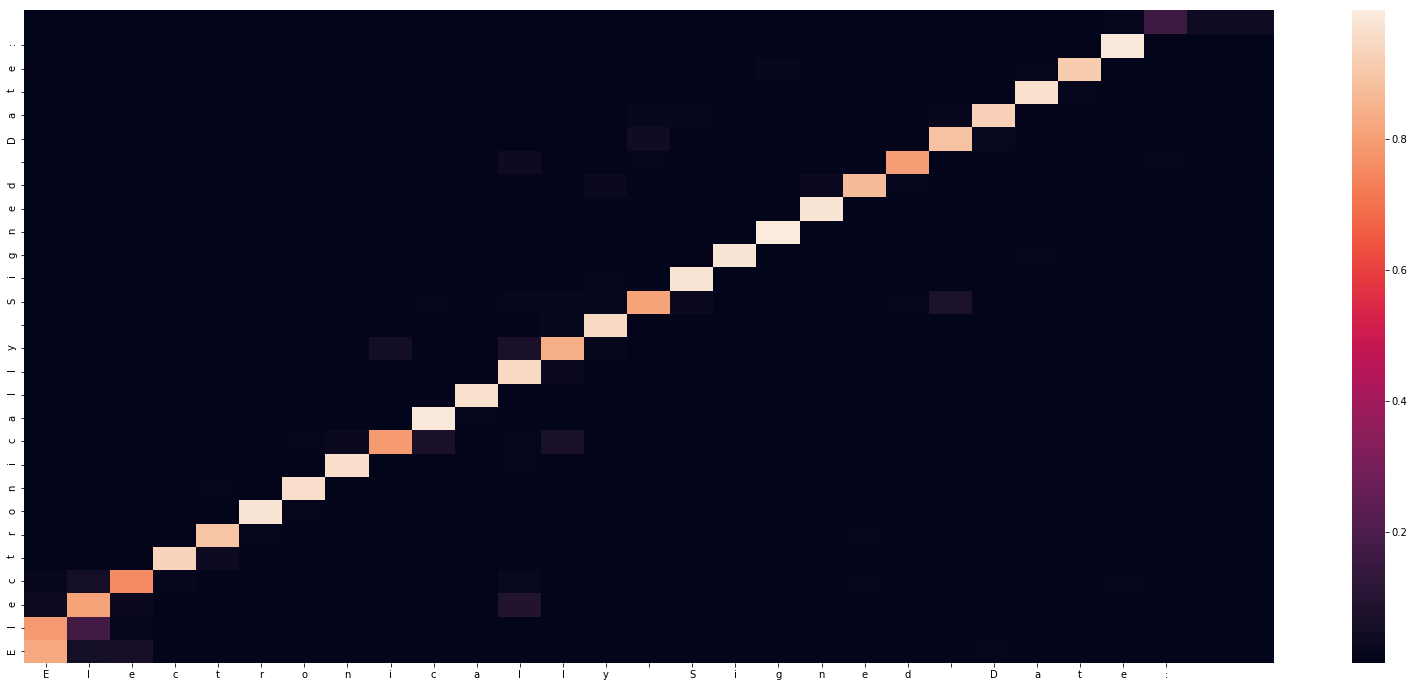

-
Input sentence: Electronically Signed Date:
GT sentence: Electronically Signed Date:

Decoded sentence: Electronically Signed Date:


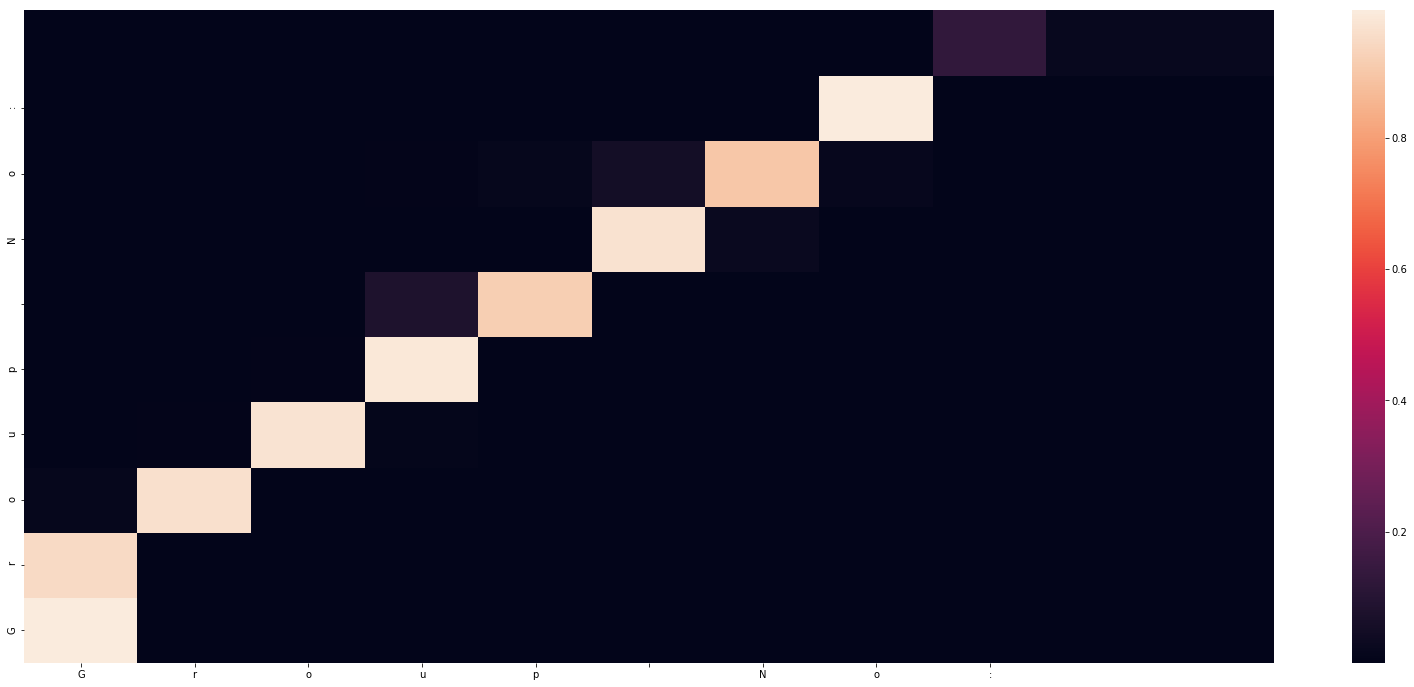

-
Input sentence: Group No:
GT sentence: Group No:

Decoded sentence: Group No:


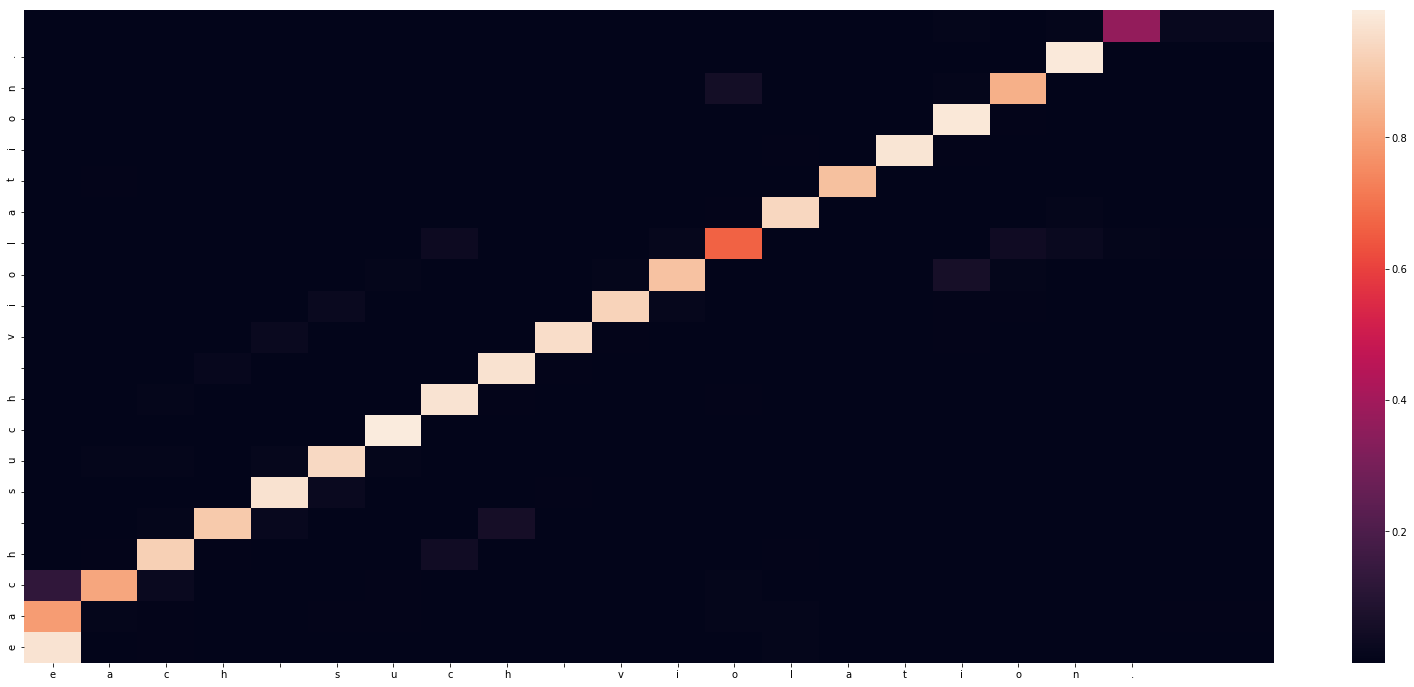

-
Input sentence: each such violation.
GT sentence: each such violation.

Decoded sentence: each such violation.


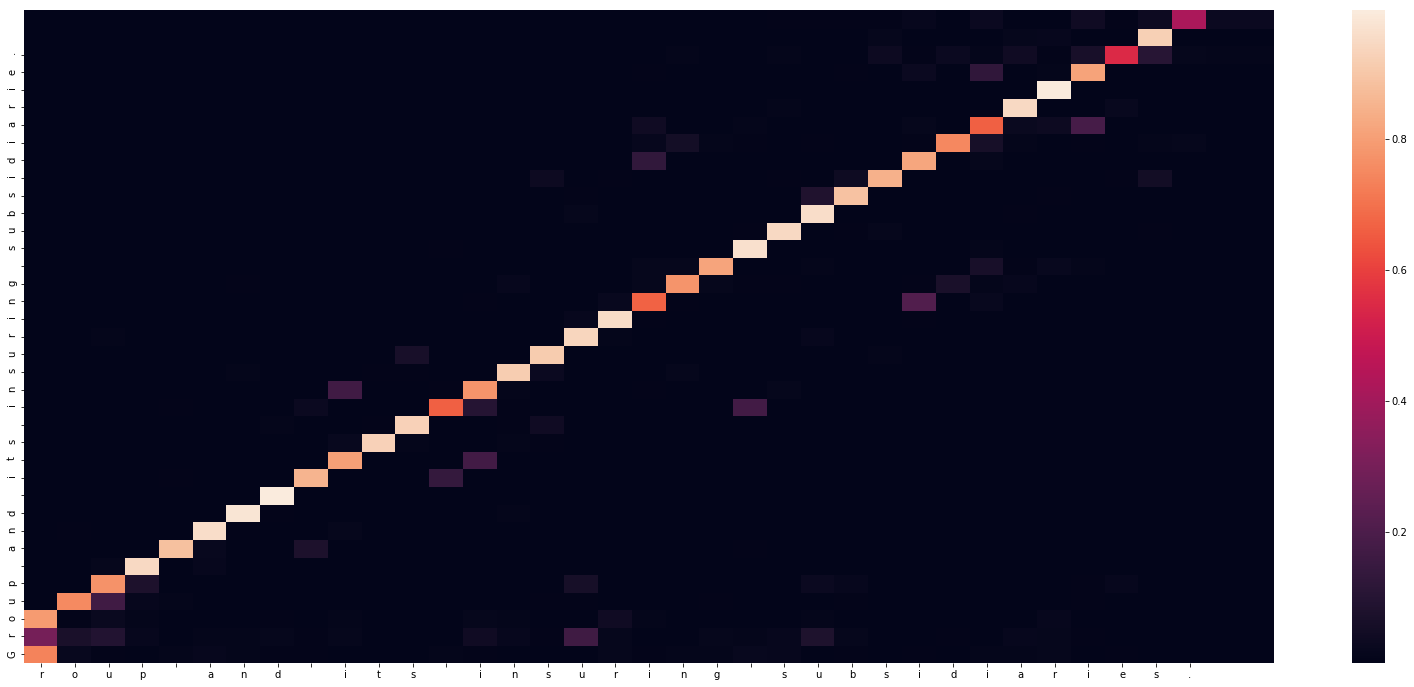

-
Input sentence: roup and its insuring subsidiaries.
GT sentence: Group and its insuring subsidiaries.

Decoded sentence: Group and its insuring subsidiarie.


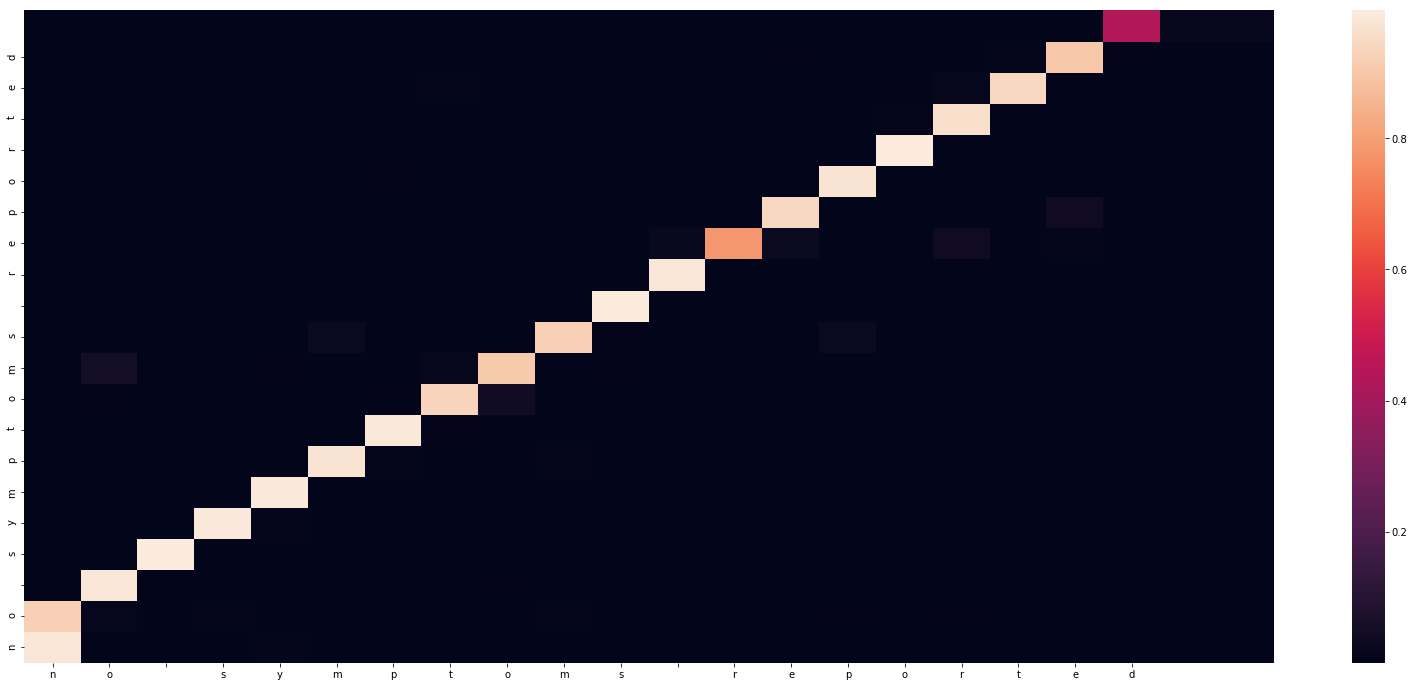

-
Input sentence: no symptoms reported
GT sentence: no symptoms reported

Decoded sentence: no symptoms reported


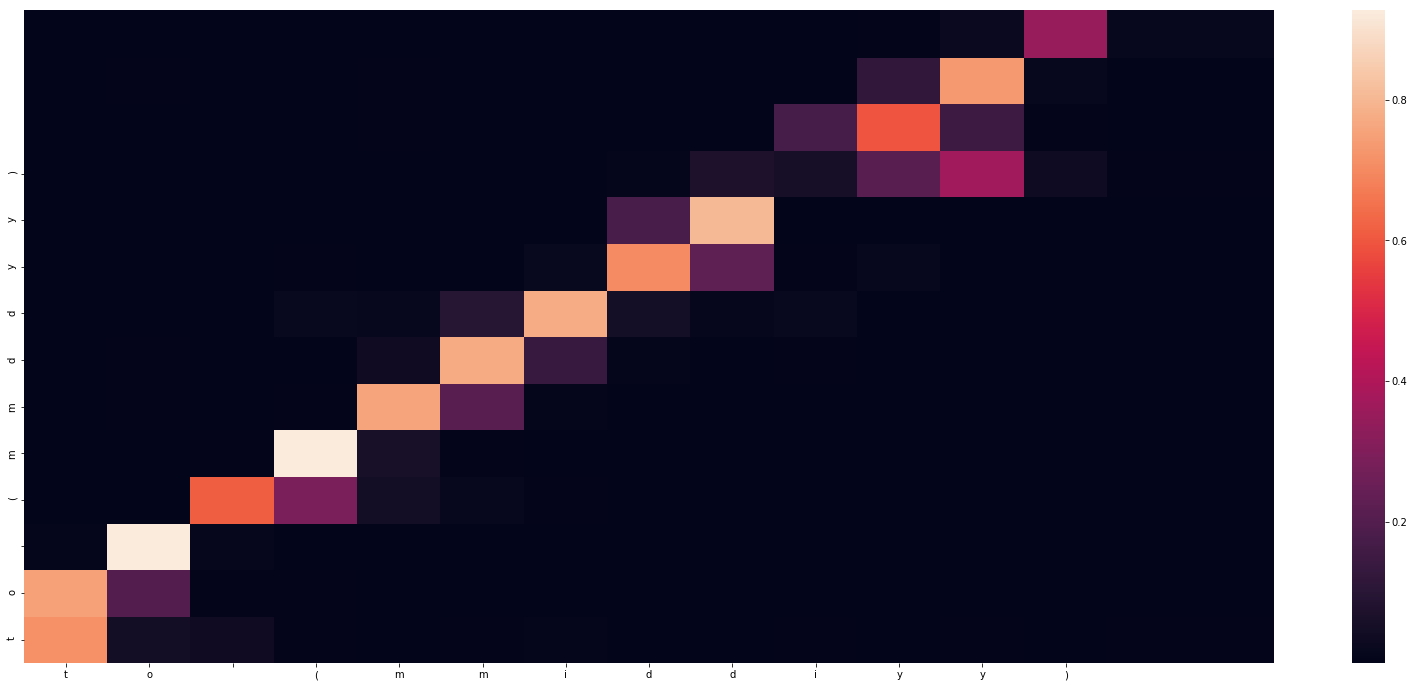

-
Input sentence: to (mmiddiyy)
GT sentence: to (mm/dd/yy)

Decoded sentence: to (mmddyy)


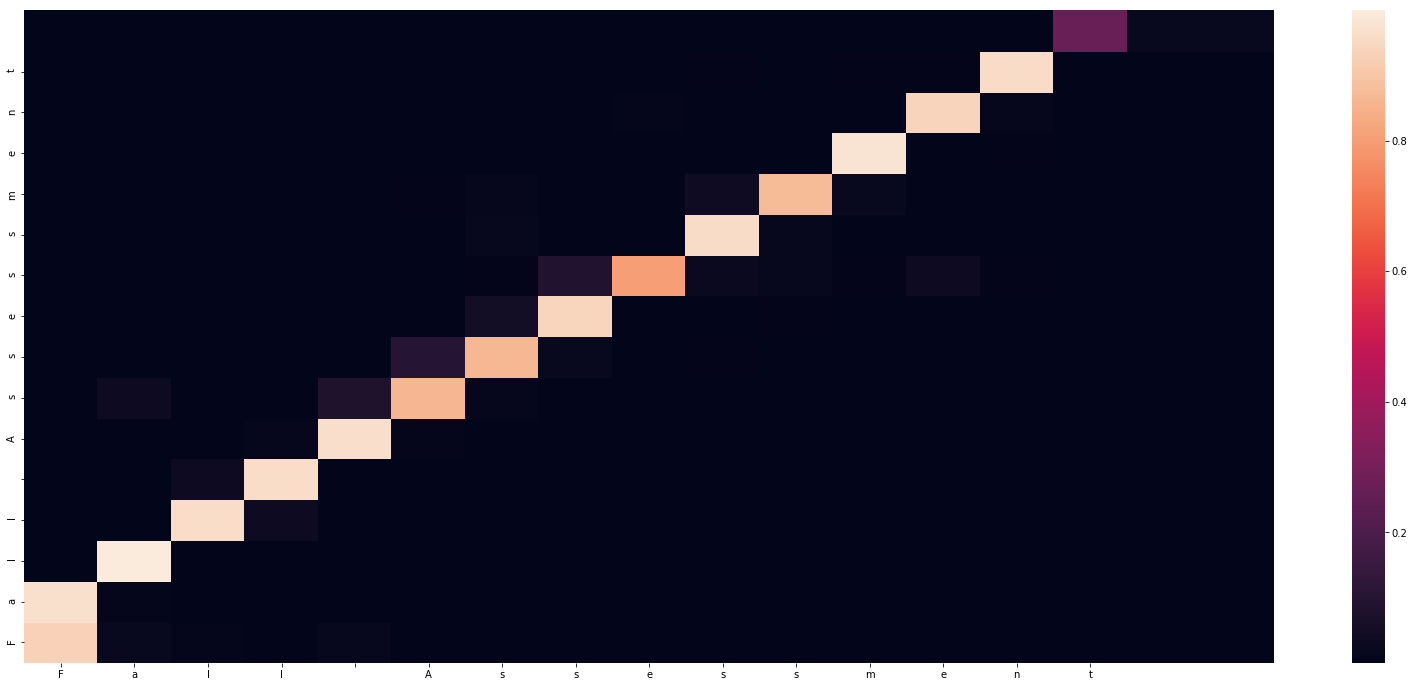

-
Input sentence: Fall Assessment
GT sentence: Fall Assessment

Decoded sentence: Fall Assessment


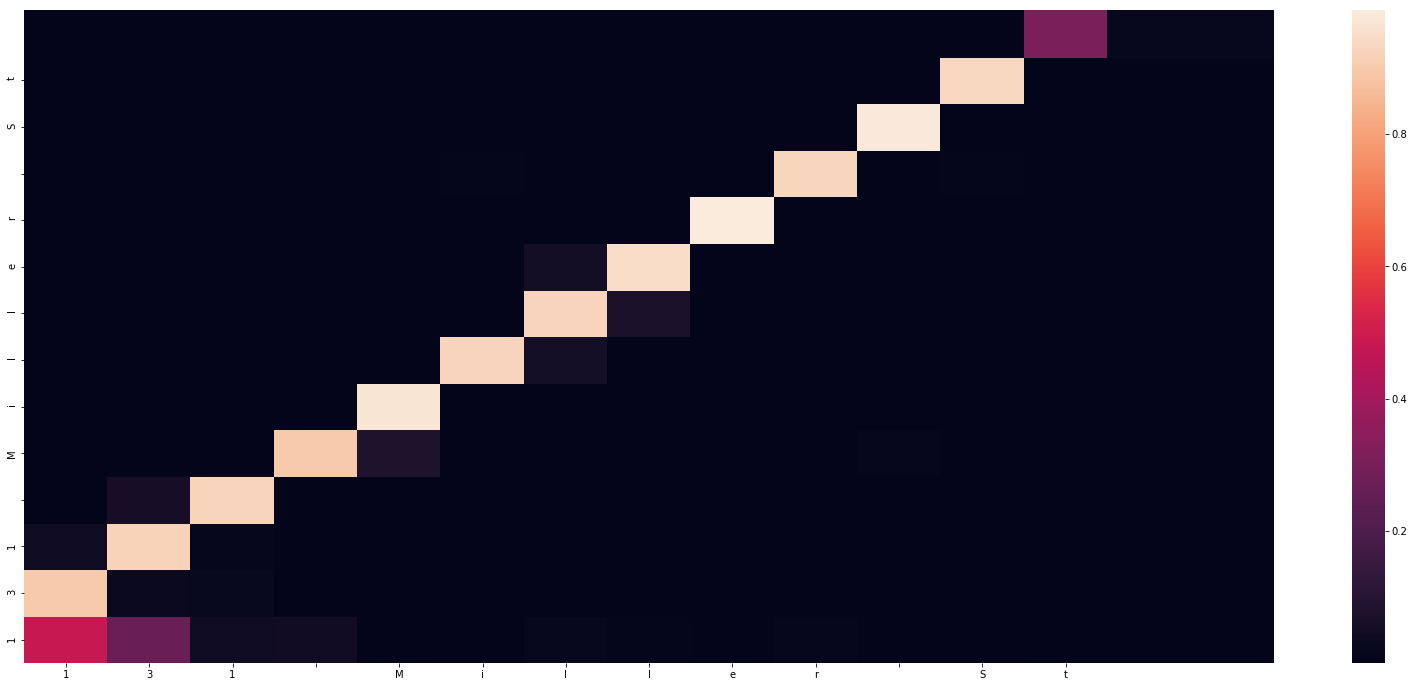

-
Input sentence: 131 Miller St
GT sentence: 131 Miller St

Decoded sentence: 131 Miller St


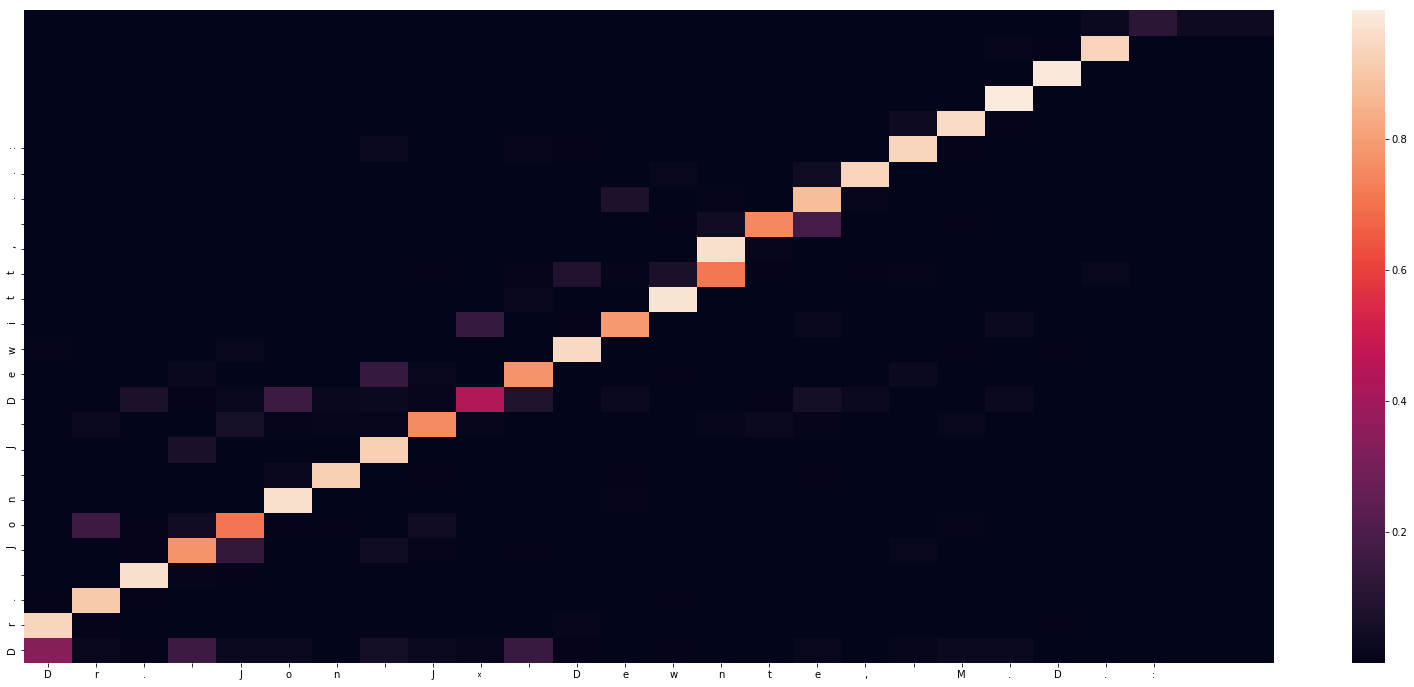

-
Input sentence: Dr. Jon J» Dewnte, M.D.:
GT sentence: Dr. Jon J. Dewitte, M.D.:

Decoded sentence: Dr. Jon J Dewitt, ..:


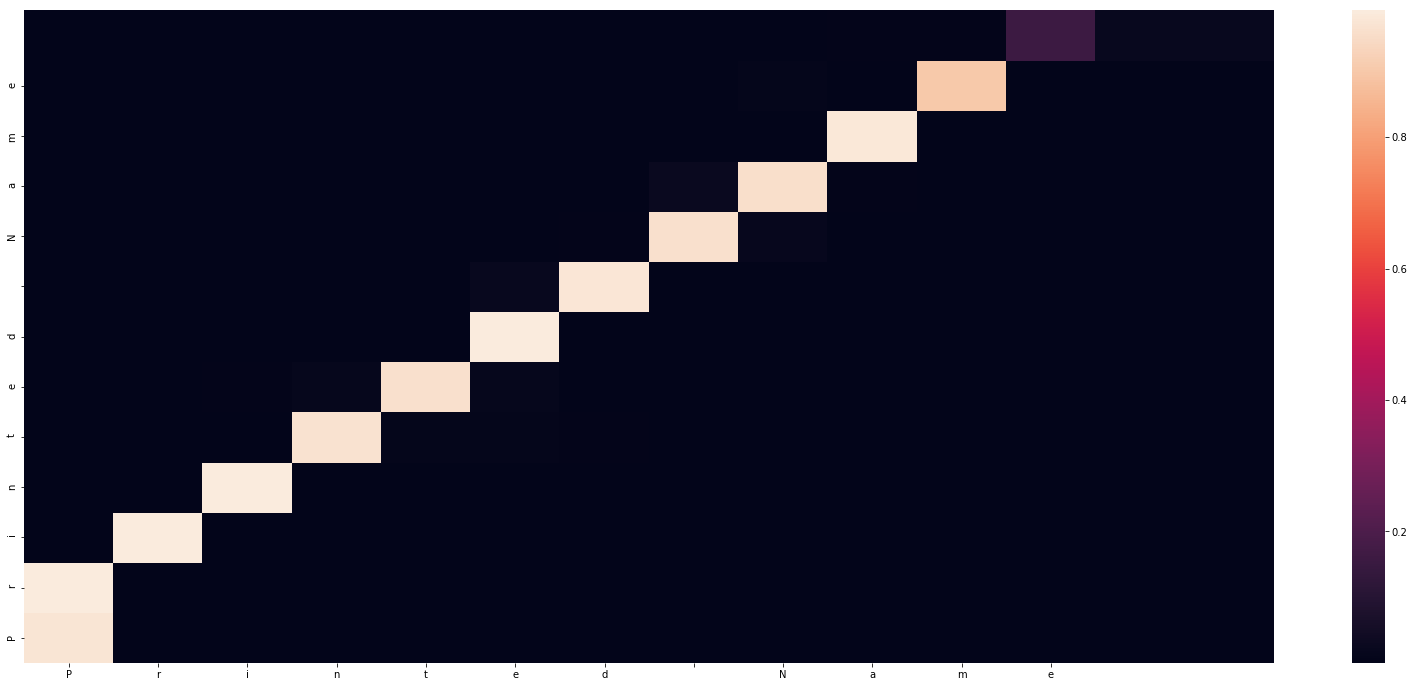

-
Input sentence: Printed Name
GT sentence: Printed Name

Decoded sentence: Printed Name


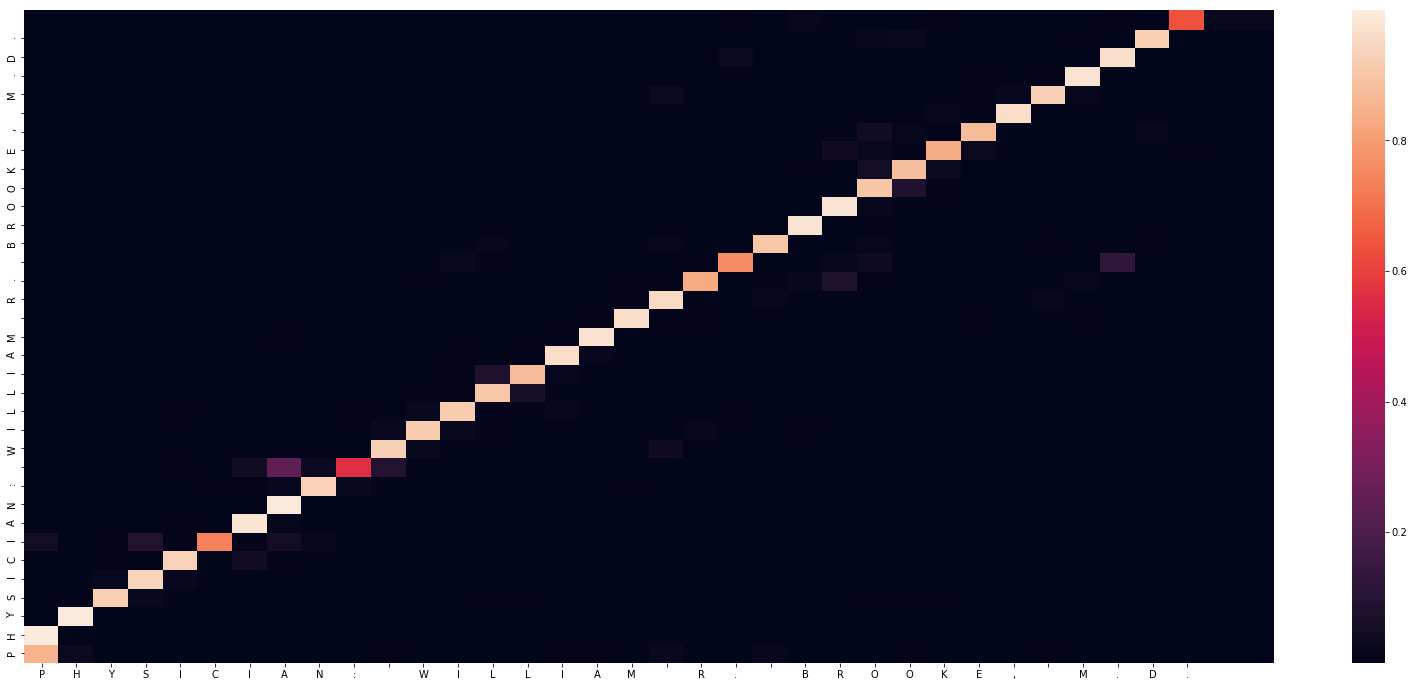

-
Input sentence: PHYSICIAN: WILLIAM R. BROOKE, M.D.
GT sentence: PHYSICIAN: WILLIAM R. BROOKE, M.D. 

Decoded sentence: PHYSICIAN: WILLIAM R. BROOKE, M.D.


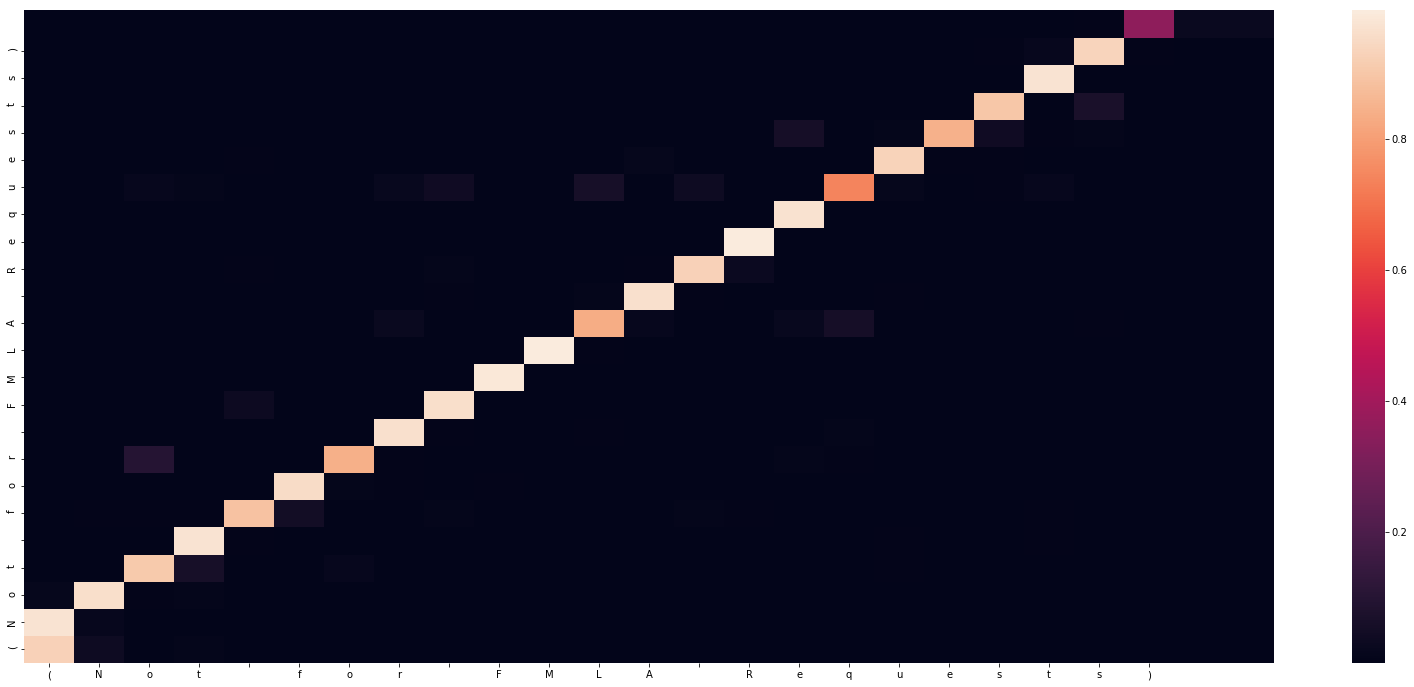

-
Input sentence: (Not for FMLA Requests)
GT sentence: (Not for FMLA Requests)

Decoded sentence: (Not for FMLA Requests)


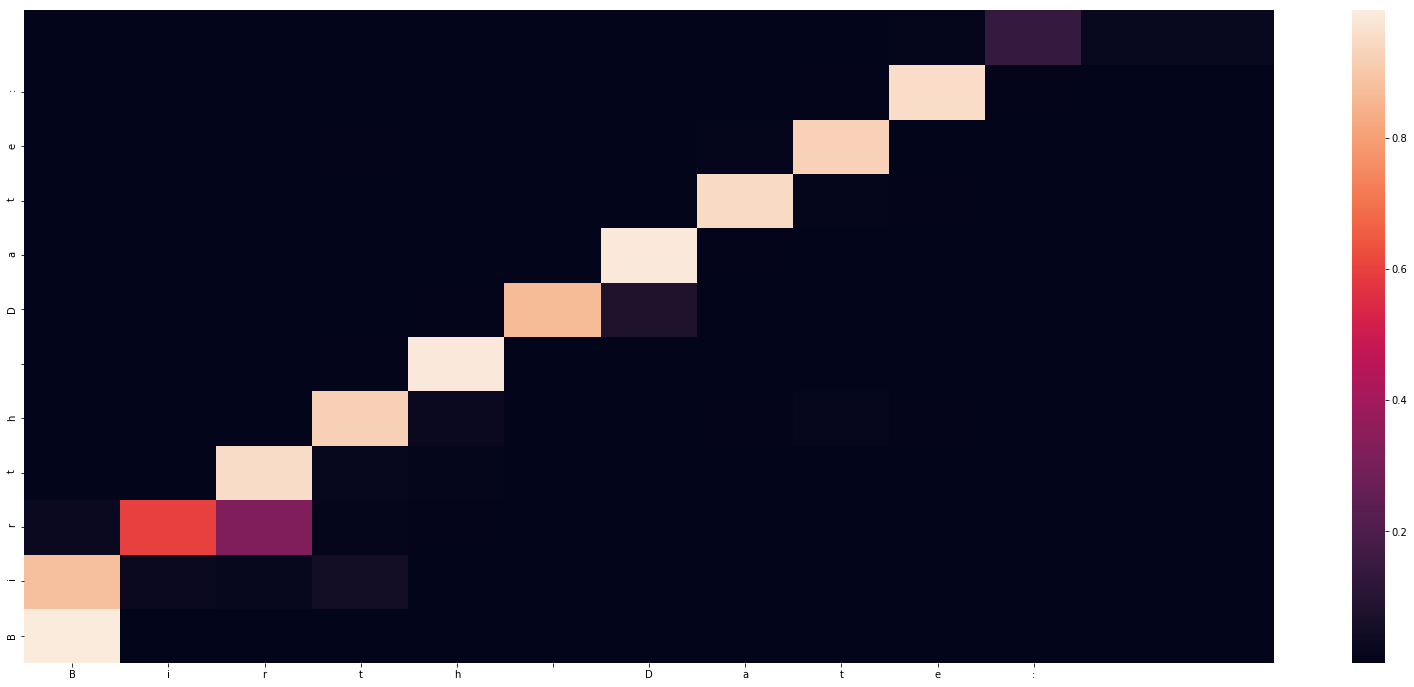

-
Input sentence: Birth Date:
GT sentence: Birth Date:

Decoded sentence: Birth Date:


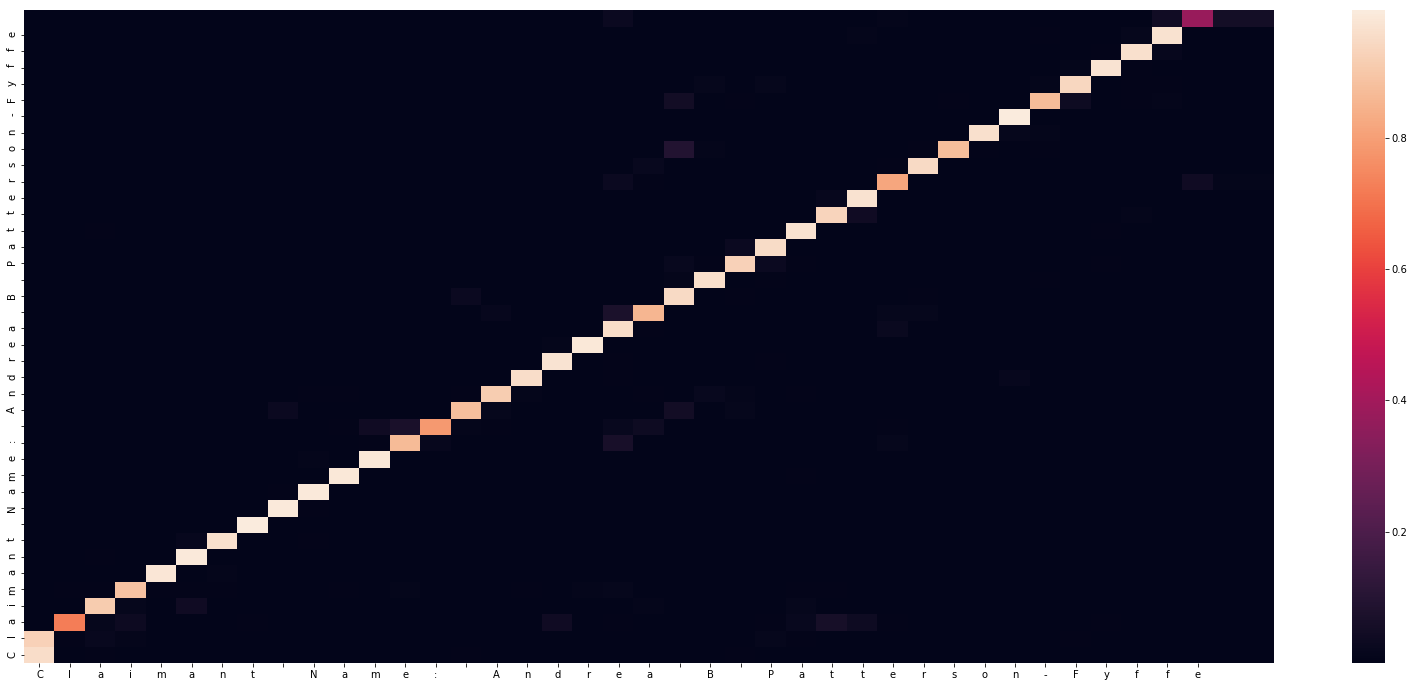

-
Input sentence: Claimant Name: Andrea B Patterson-Fyffe
GT sentence: Claimant Name: Andrea B Patterson-Fyffe

Decoded sentence: Claimant Name: Andrea B Patterson-Fyffe


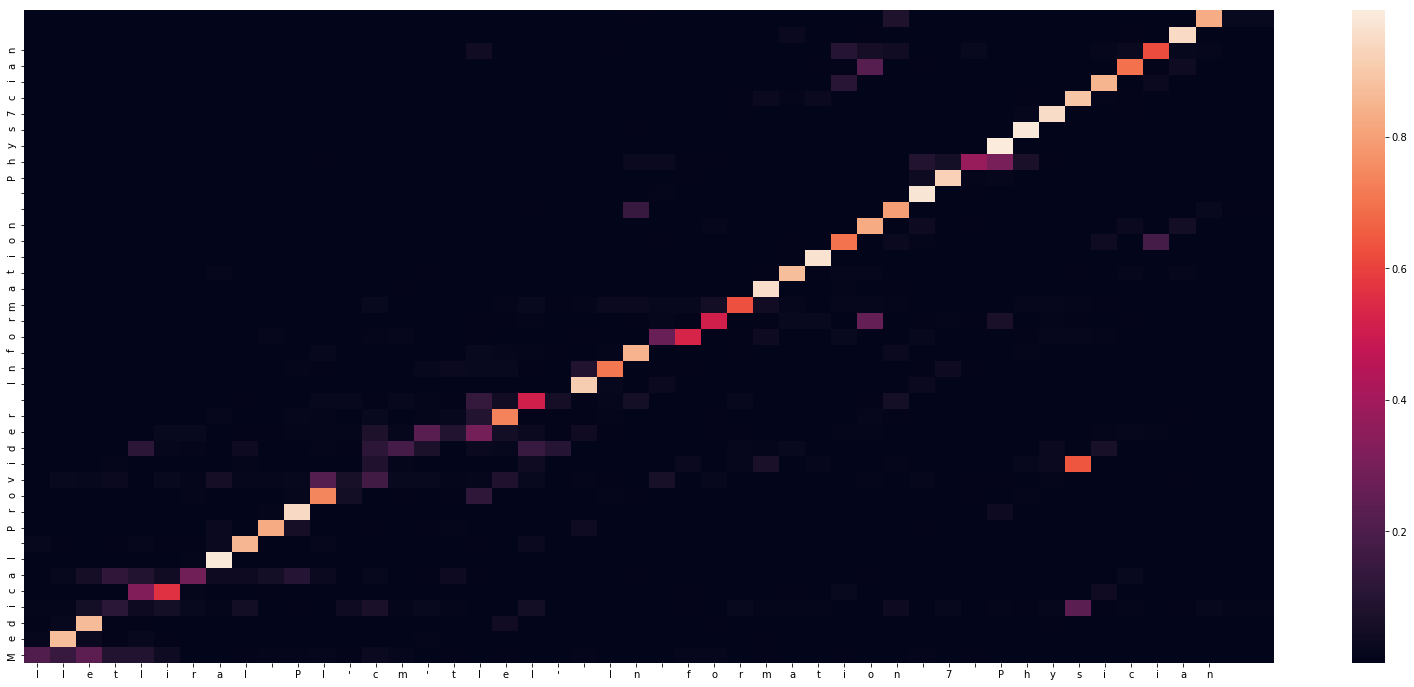

-
Input sentence: lletliral Pl'cm'tlel' In formation 7 Physician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medical Provider Information  Phys7cian


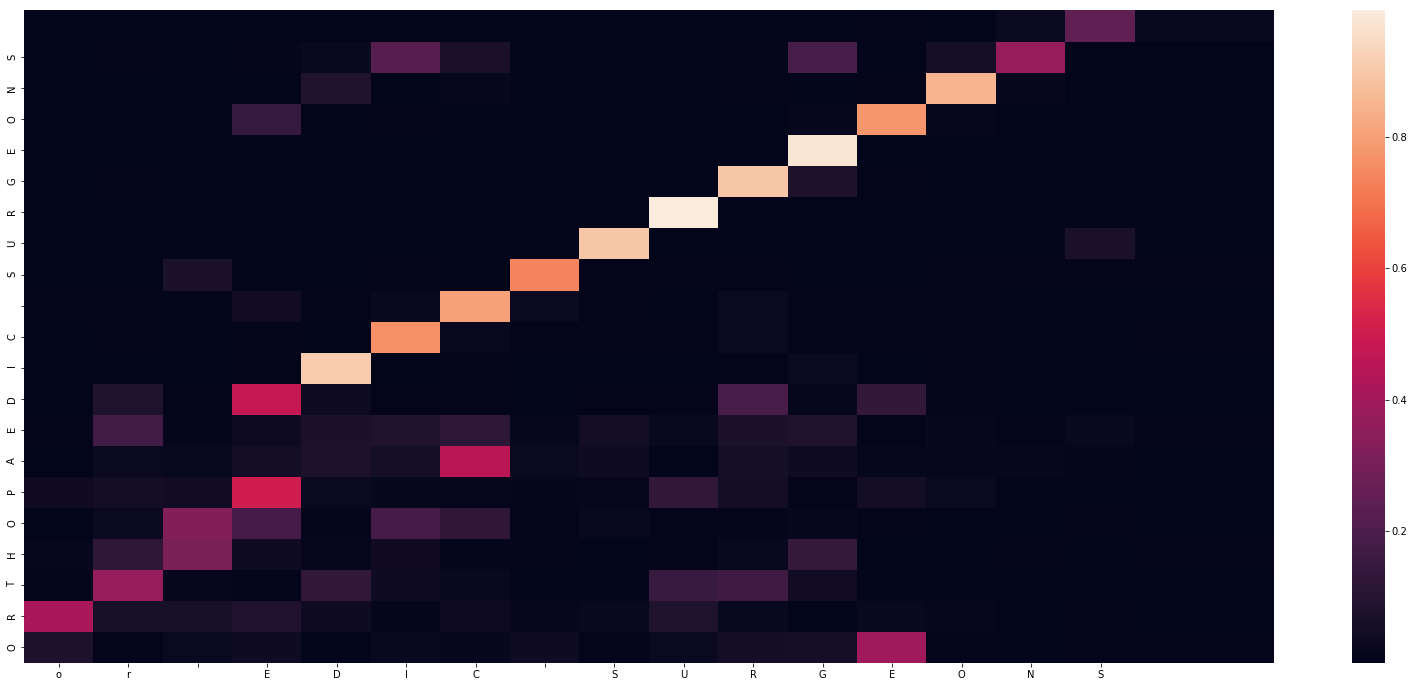

-
Input sentence: or EDIC SURGEONS
GT sentence: ORTHOPAEDIC SURGEONS

Decoded sentence: ORTHOPAEDIC SURGEONS


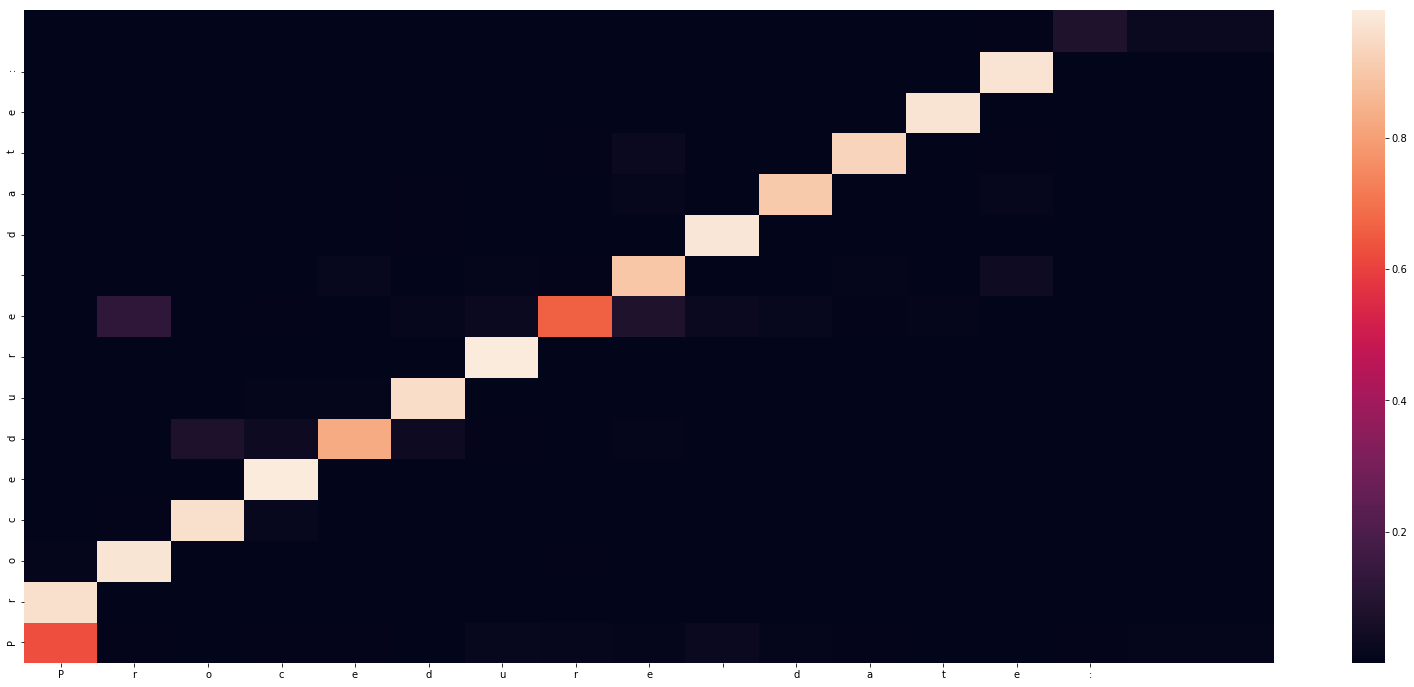

-
Input sentence: Procedure date:
GT sentence: Procedure date:

Decoded sentence: Procedure date:


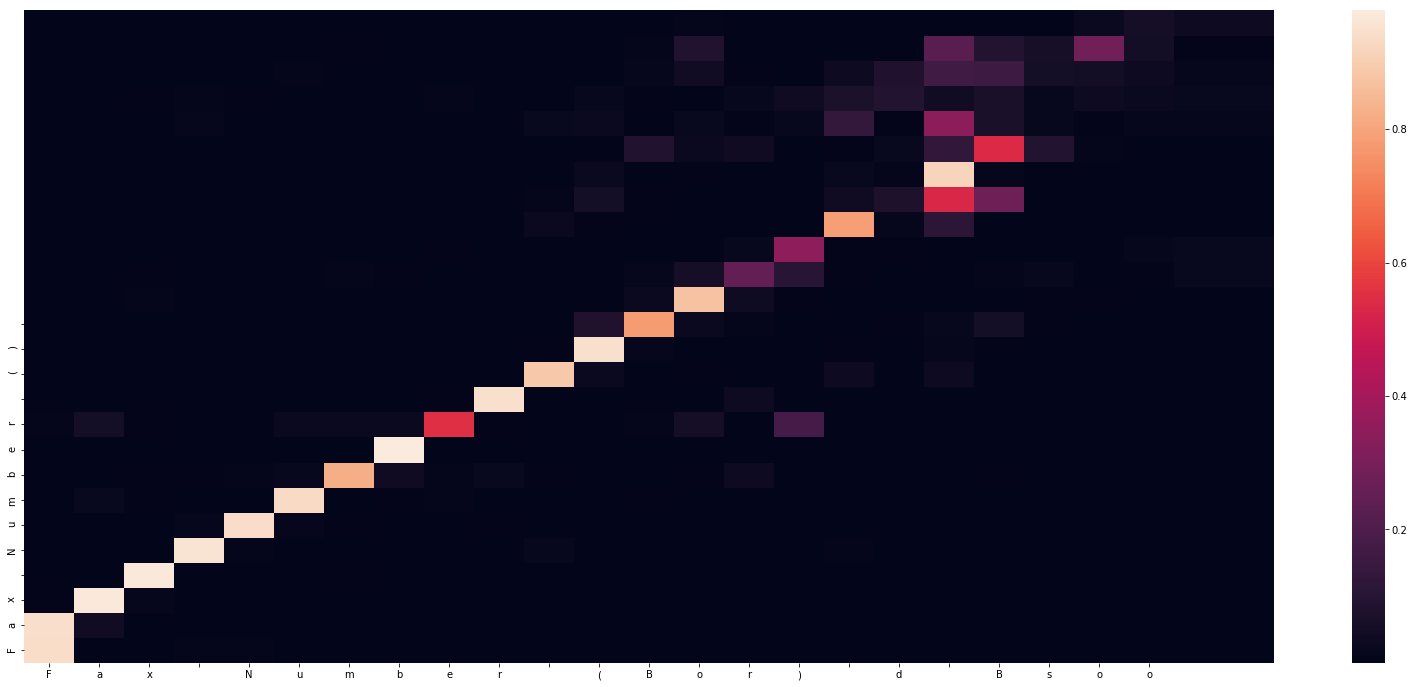

-
Input sentence: Fax Number (Bor) d Bsoo
GT sentence: Fax Number (308) 728-3500

Decoded sentence: Fax Number () 


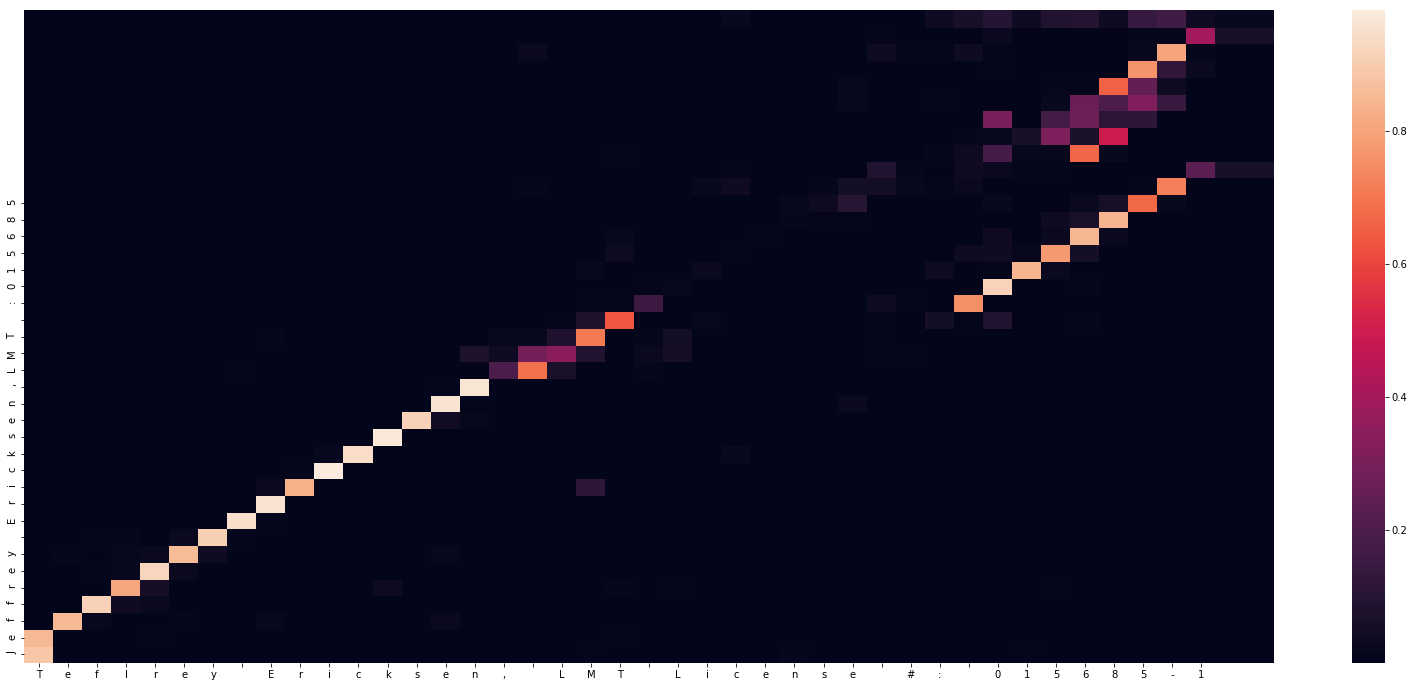

-
Input sentence: Teflrey Ericksen, LMT License #: 015685-1
GT sentence: Jeffrey Ericksen,LMT  License #:015685-1

Decoded sentence: Jeffrey Ericksen,LMT :015685


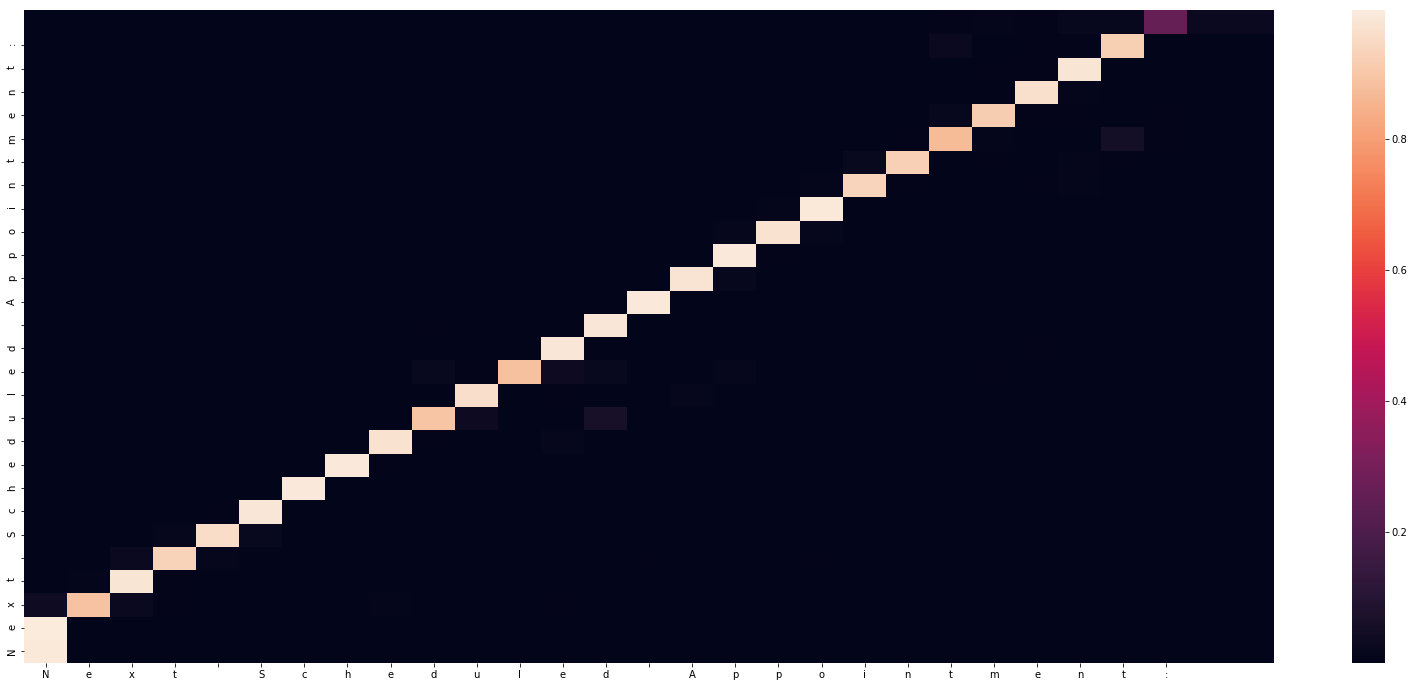

-
Input sentence: Next Scheduled Appointment:
GT sentence: Next Scheduled Appointment:

Decoded sentence: Next Scheduled Appointment:


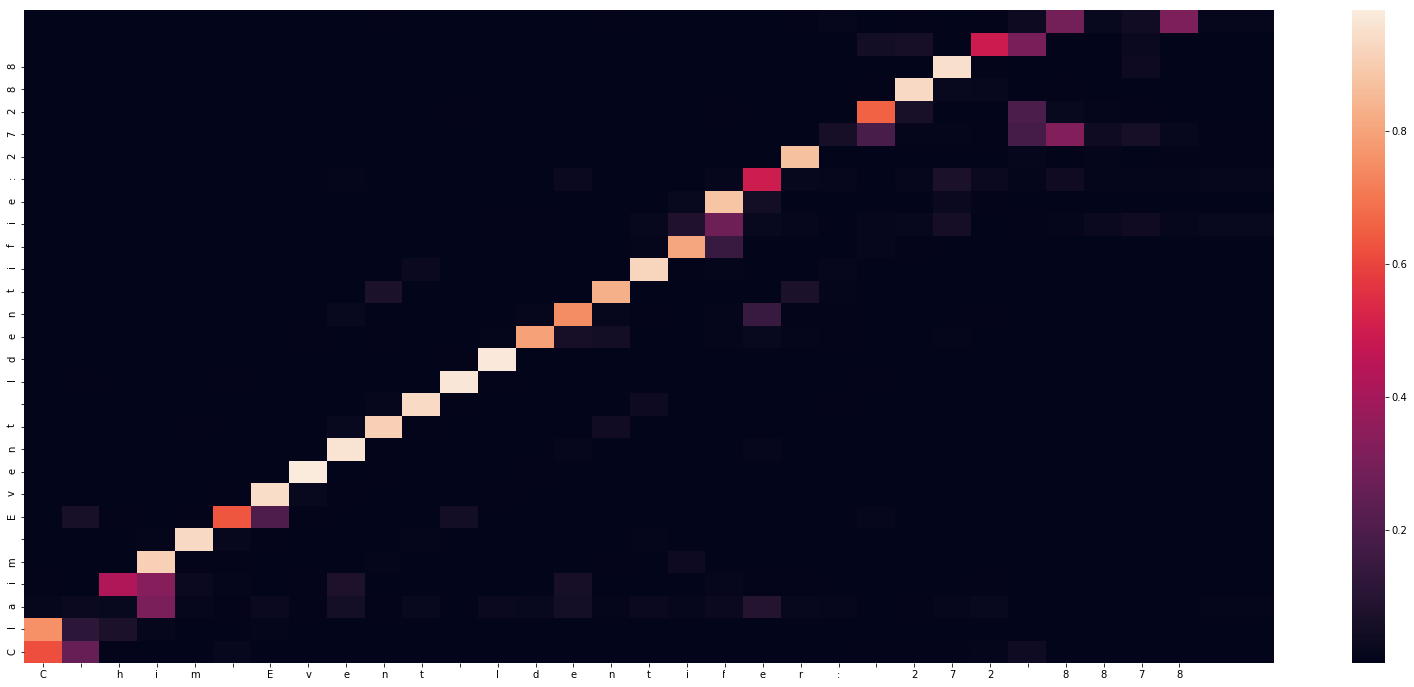

-
Input sentence: C him Event Identiﬁer: 272 8878
GT sentence: Claim Event Identifier: 2728878

Decoded sentence: Claim Event Identifie:27288


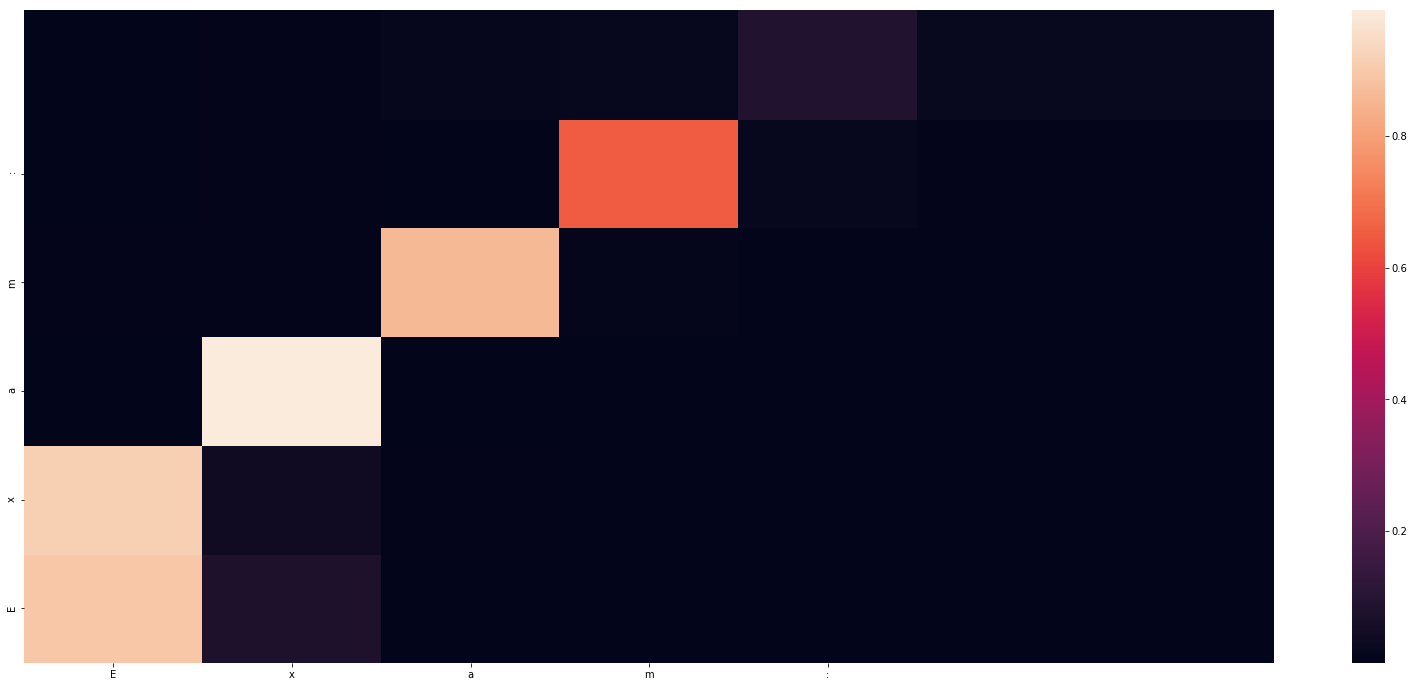

-
Input sentence: Exam:
GT sentence: Exam:

Decoded sentence: Exam:


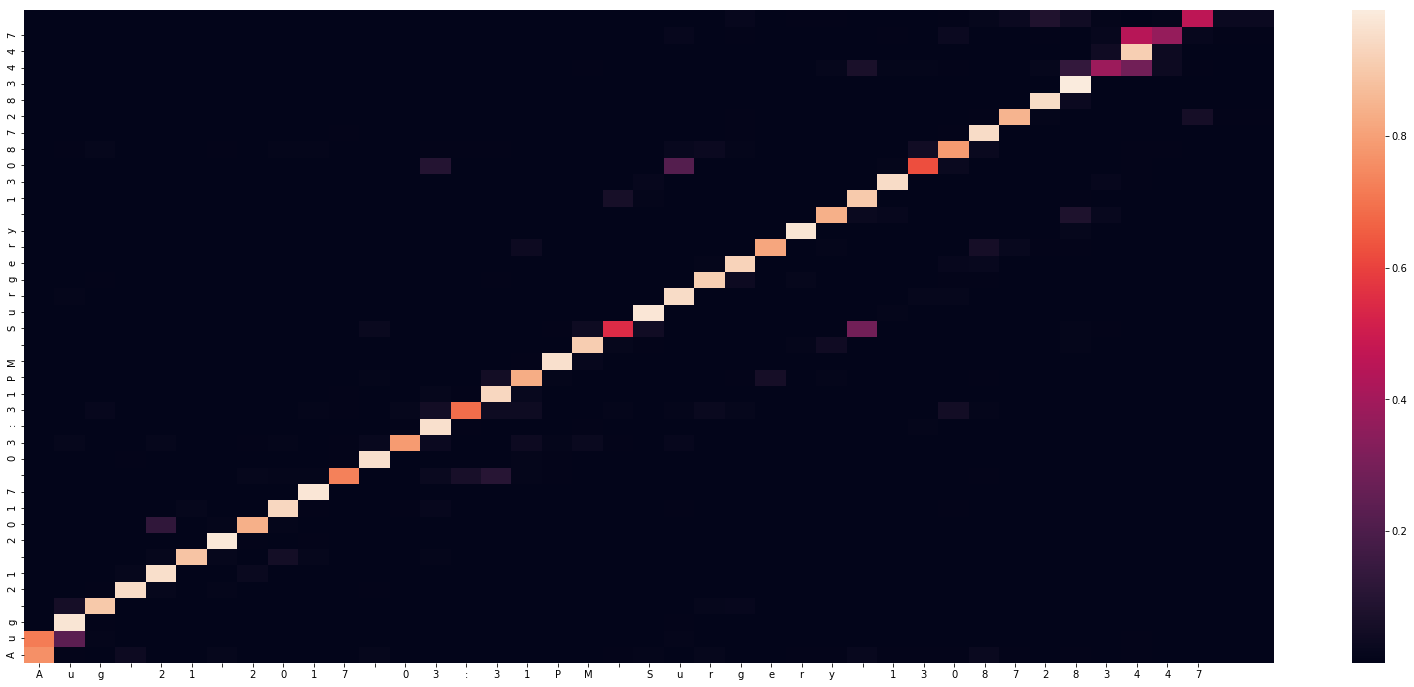

-
Input sentence: Aug 21 2017 03:31PM Surgery 13087283447
GT sentence: Aug 21 2017 03:31PM Surgery 13087283447

Decoded sentence: Aug 21 2017 03:31PM Surgery 13087283447


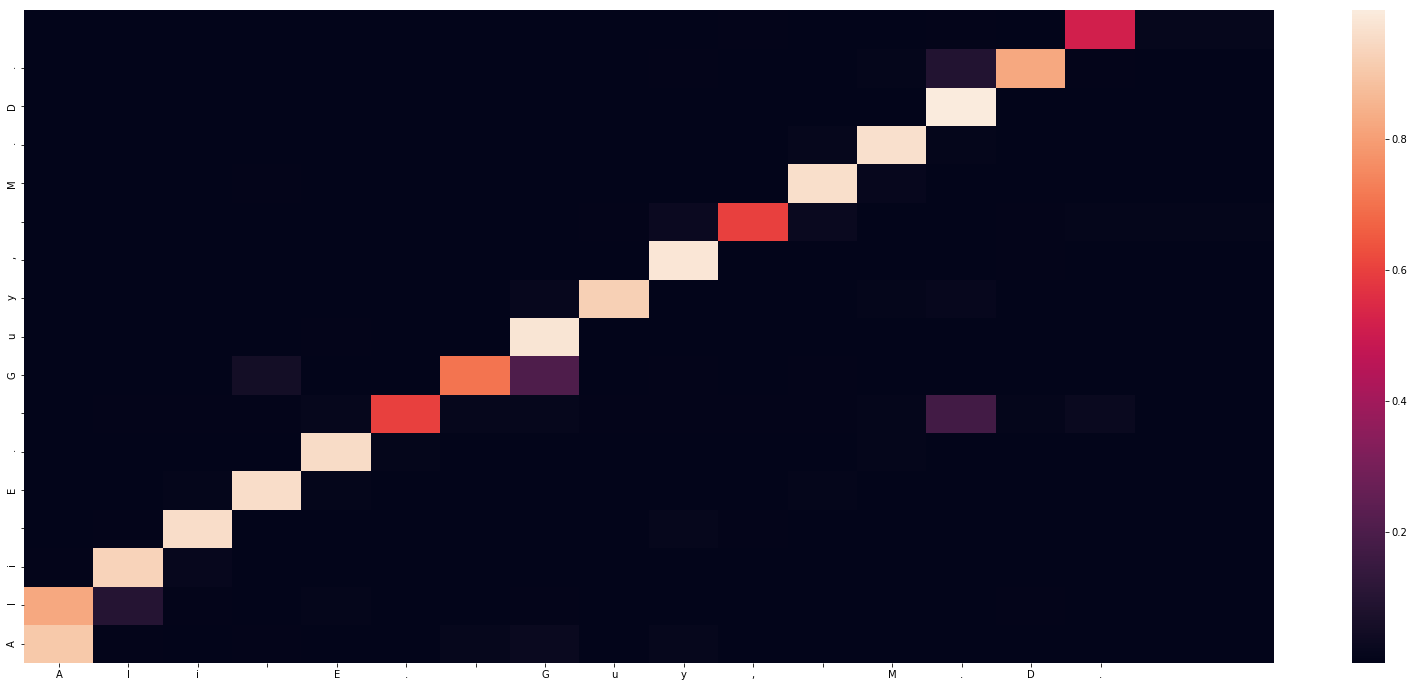

-
Input sentence: Ali E. Guy, M.D.
GT sentence: Ali E. Guy,M.D.

Decoded sentence: Ali E. Guy, M.D.


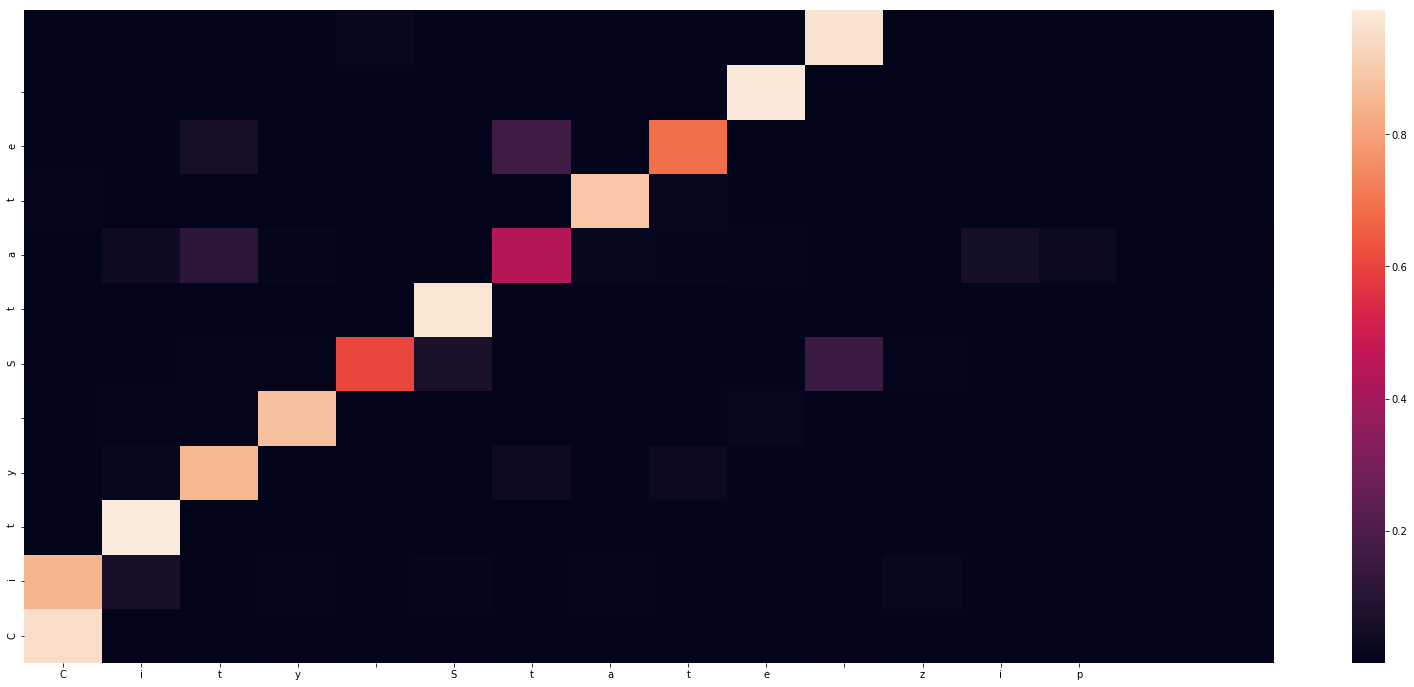

-
Input sentence: City State zip
GT sentence: City State Zip

Decoded sentence: City State 


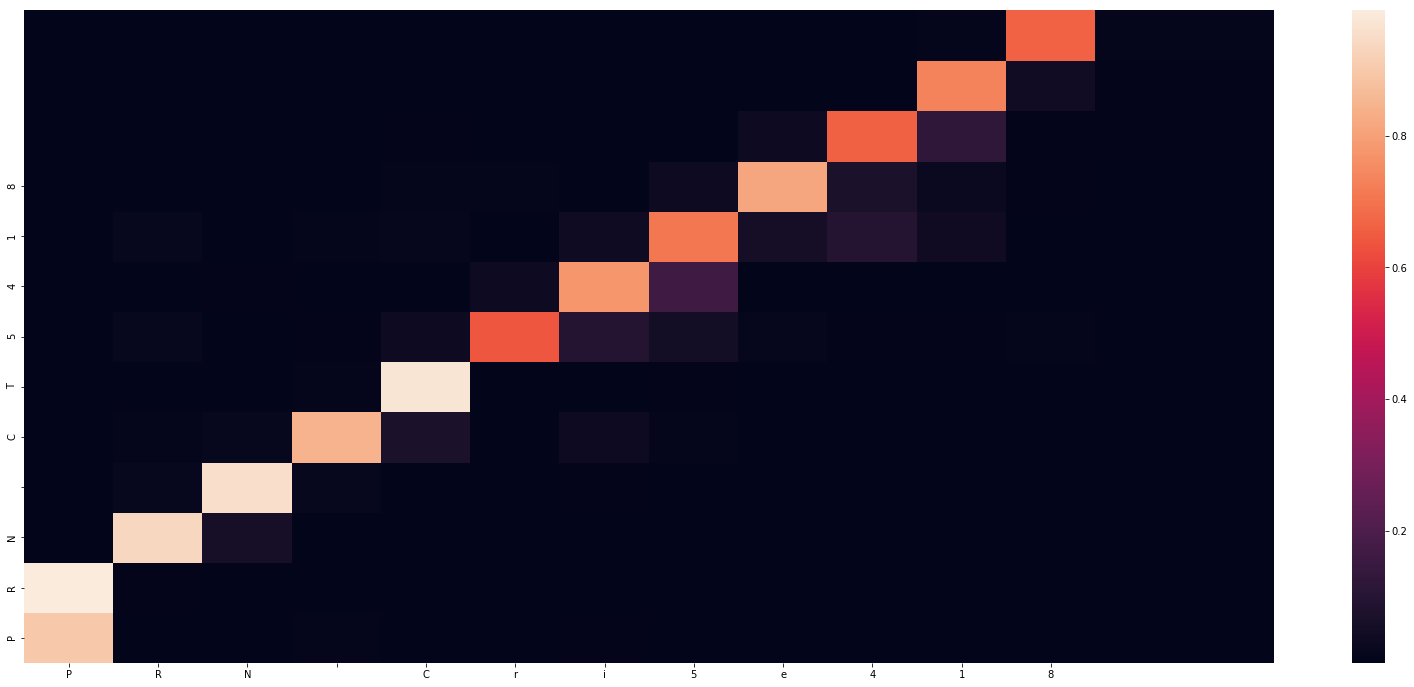

-
Input sentence: PRN Cri5e418
GT sentence: PRN CT156418

Decoded sentence: PRN CT5418


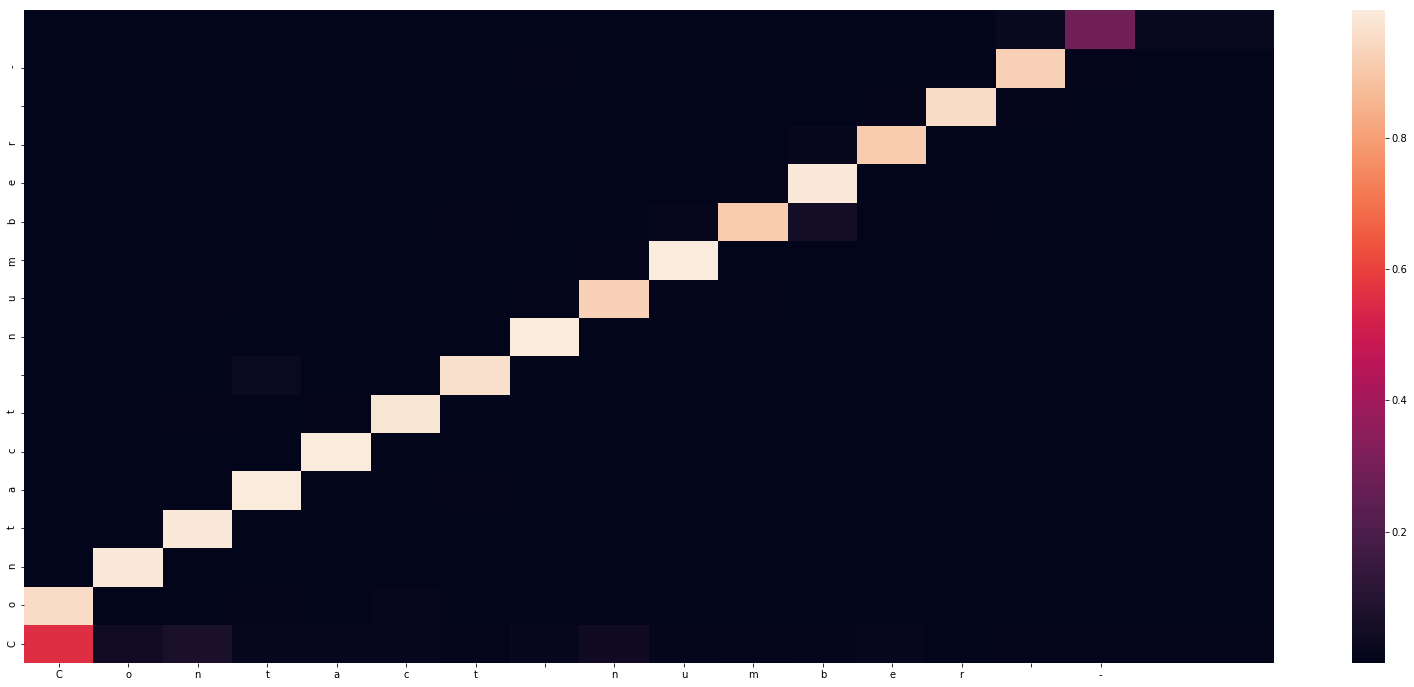

-
Input sentence: Contact number -
GT sentence: Contact number -

Decoded sentence: Contact number -


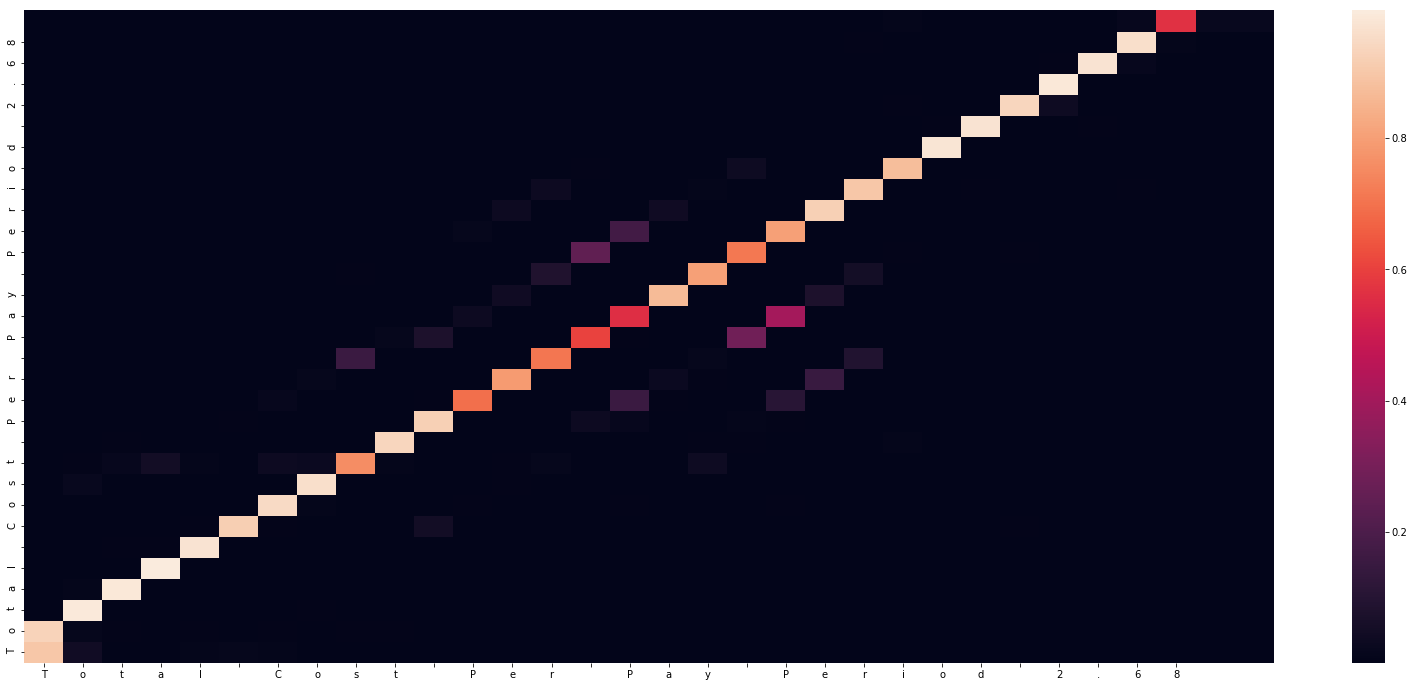

-
Input sentence: Total Cost Per Pay Period 2.68
GT sentence: Total Cost Per Pay Period 2.68

Decoded sentence: Total Cost Per Pay Period 2.68


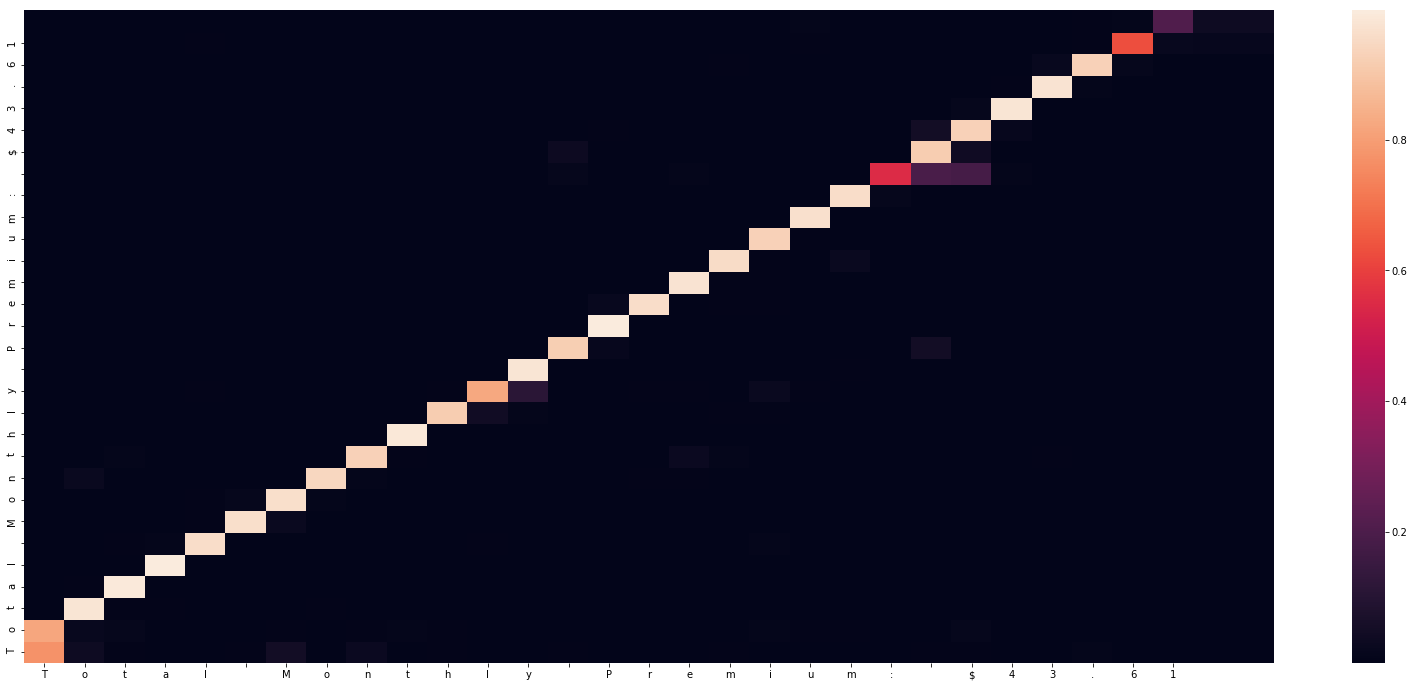

-
Input sentence: Total Monthly Premium: $43.61
GT sentence: Total Monthly Premium: $43.61

Decoded sentence: Total Monthly Premium: $43.61


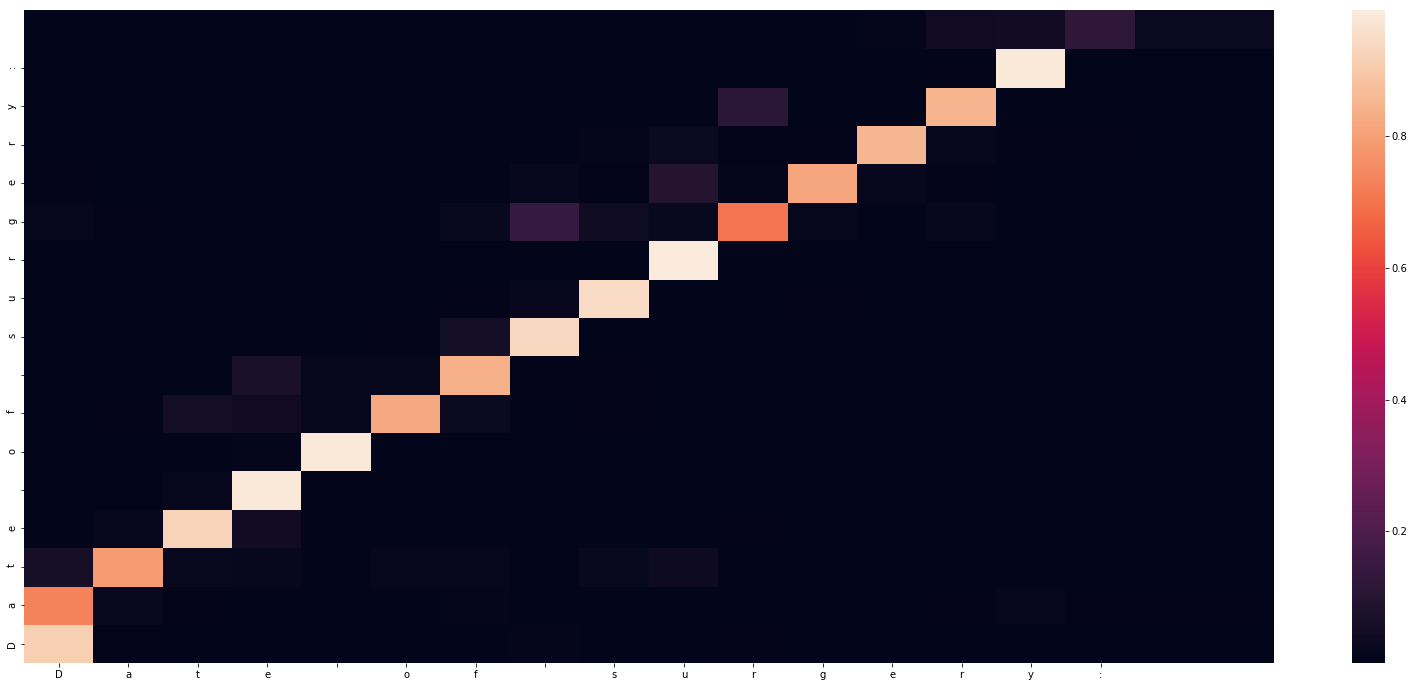

-
Input sentence: Date of surgery:
GT sentence: Date of surgery:

Decoded sentence: Date of surgery:


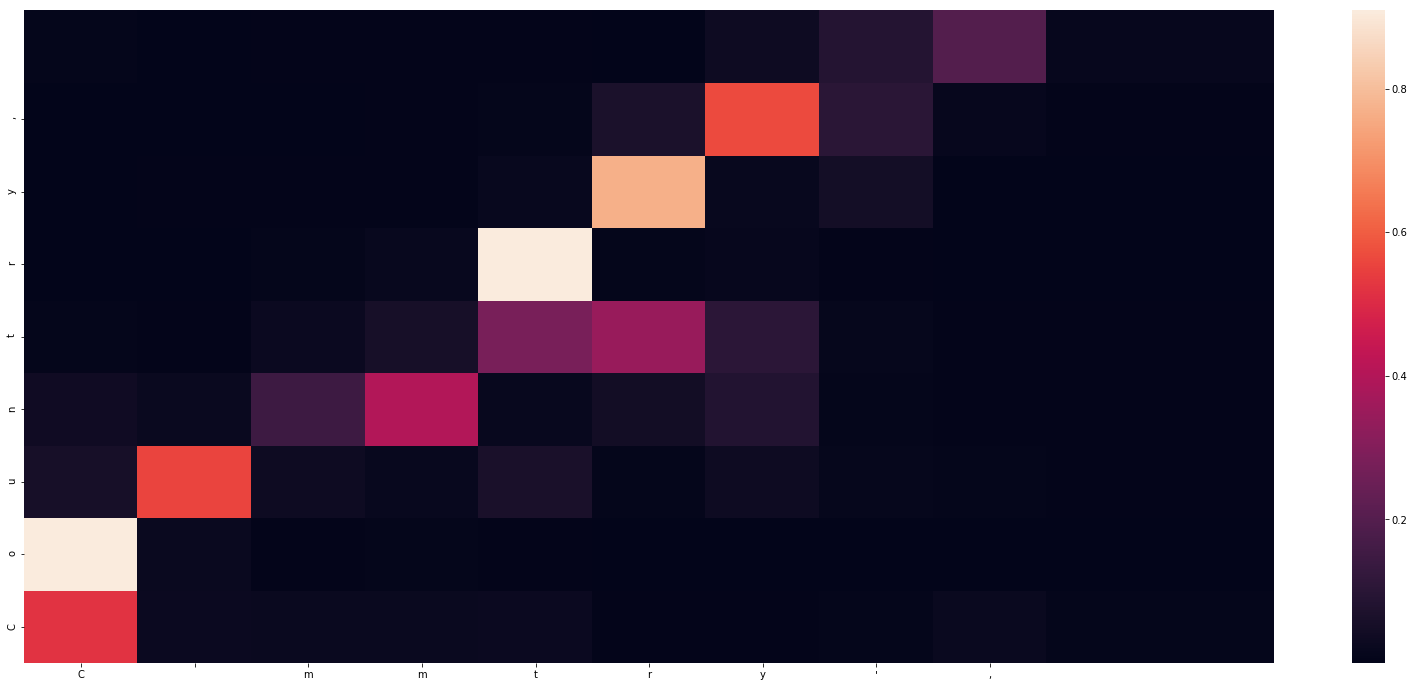

-
Input sentence: C mmtry',
GT sentence: Country:

Decoded sentence: Country,


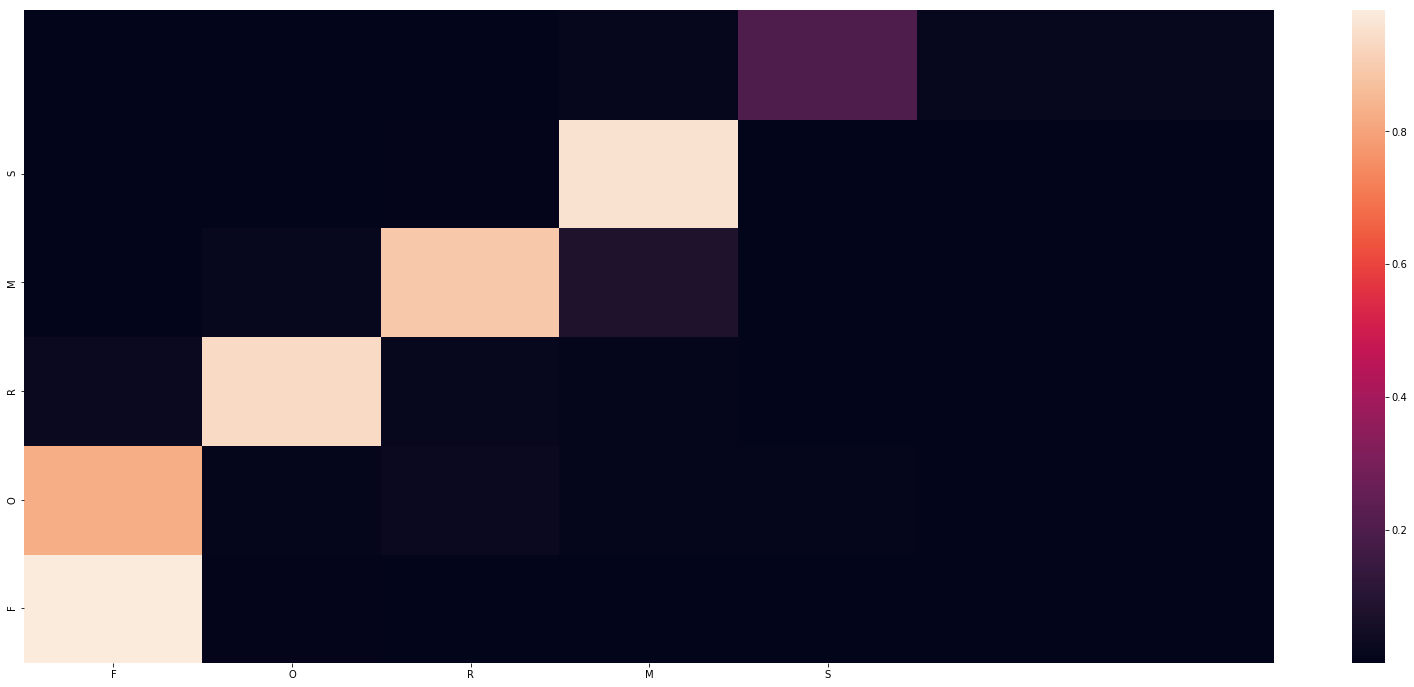

-
Input sentence: FORMS
GT sentence: FORMS

Decoded sentence: FORMS


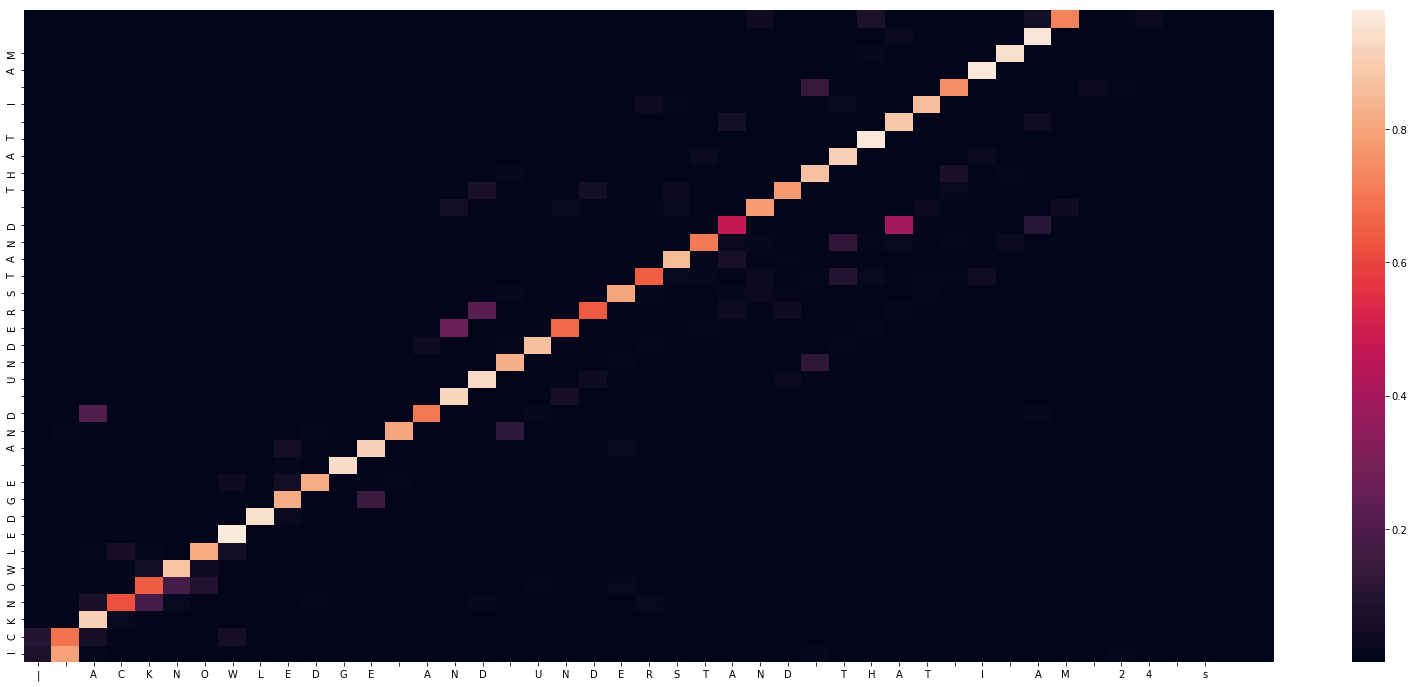

-
Input sentence: | ACKNOWLEDGE AND UNDERSTAND THAT I AM 24 s
GT sentence: I ACKNOWLEDGE AND UNDERSTAND THAT I AM

Decoded sentence: ICKNOWLEDGE AND UNDERSTAND THAT I AM


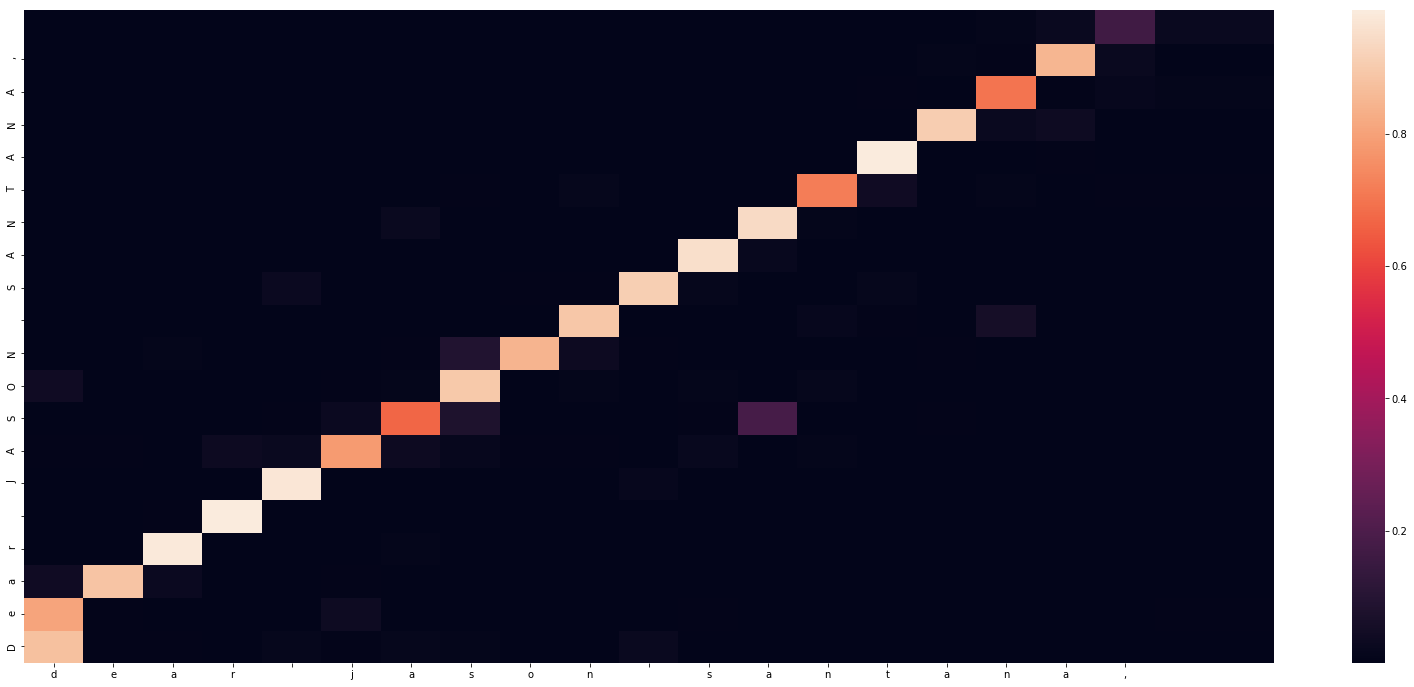

-
Input sentence: dear jason santana,
GT sentence: Dear JASON SANTANA,

Decoded sentence: Dear JASON SANTANA,


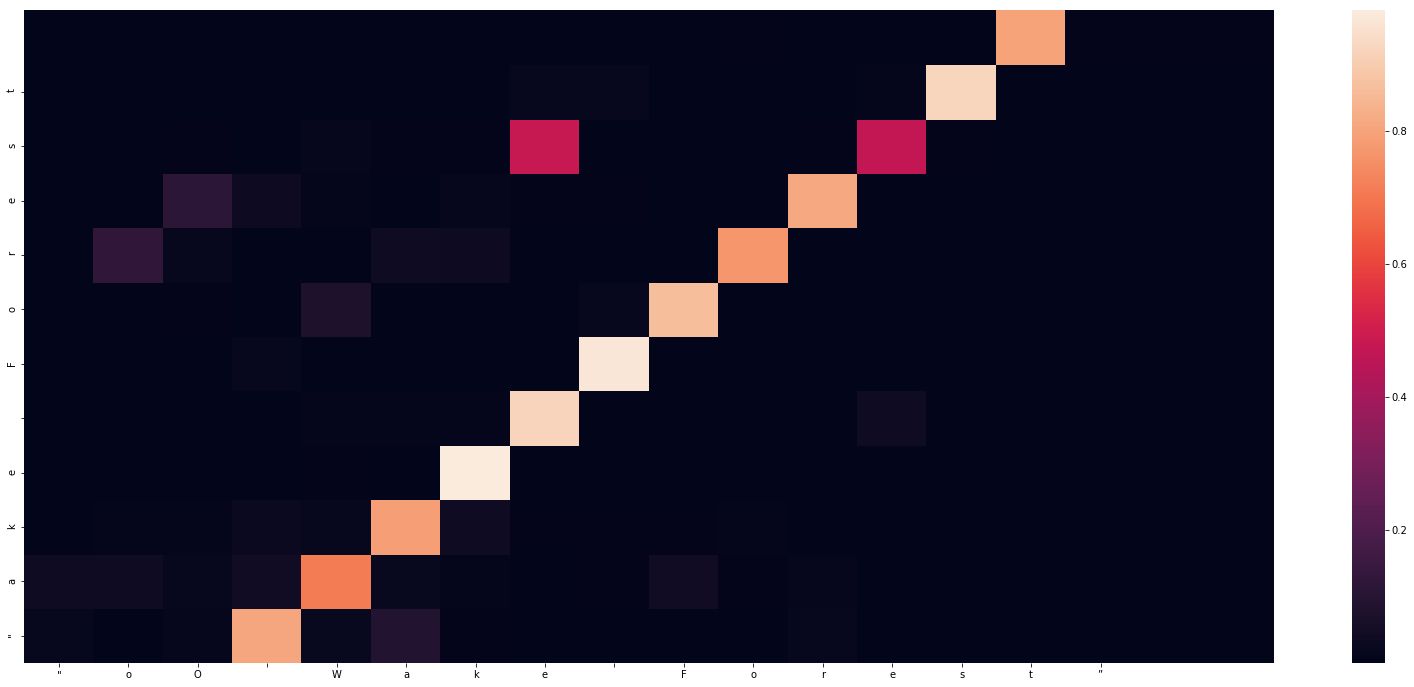

-
Input sentence: "oO Wake Forest”
GT sentence: Wake Forest

Decoded sentence: "ake Forest


In [ ]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   


# Test - Short inference

In [39]:
from autocorrect import spell
import re
special_chars = ['\\', '\/', '\-', '\—' , '\:', '\[', '\]', '\,', '\.', '\"', '\;', '\%', '\~', '\(', '\)', '\{', '\}', '\$', '\&', '\#', '\☒', '\■', '\☐', '\□', '\☑', '\@']
special_chars_s = '[' + ''.join(special_chars) + ']'
def word_spell_correct(decoded_sentence):
    if(decoded_sentence == ''):
        return ''
    corrected_decoded_sentence = ''

    for w in decoded_sentence.split(' '):
        #print(w)
        #if((len(re.findall(r'\d+', w))==0) and not (w in special_chars)):
        if((len(re.findall(r'\d+', w))==0) and (len(re.findall(special_chars_s, w))==0)):
            corrected_decoded_sentence += spell(w) + ' '
        else:
            corrected_decoded_sentence += w + ' '
    return corrected_decoded_sentence

In [ ]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
corrected_sentences = []
corrected_input_sentences = []
results = open('RESULTS_NEW_MODEL.md', 'w')
results.write('|OCR sentence|GT sentence|Old model corrected sentence|New model corrected sentence|\n')
results.write('|------------|-----------|----------------------------|----------------------------|\n')
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_text = test_input_texts[seq_index]
    target_text = test_target_texts[seq_index][1:-1]
    splits = split_ngrams(input_text, n=30)
    decoded_splits = []
    for split in splits:    
        encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=[split],
                                                                                     target_texts=[target_text], 
                                                                                     max_encoder_seq_length=max_encoder_seq_length, 
                                                                                     num_encoder_tokens=num_encoder_tokens, 
                                                                                     vocab_to_int=vocab_to_int)    

        input_seq = encoder_input_data
        #target_seq = np.argmax(decoder_target_data, axis=-1)
        #print(target_seq)
        decoded_split, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, max_encoder_seq_length, int_to_vocab, vocab_to_int)
        decoded_splits.append(decoded_split)
    decoded_sentence = ' '.join(decoded_splits) 
    print('-')
    print('Input sentence:', input_text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)
    corrected_sentence = word_spell_correct(decoded_sentence)
    print('Corrected sentence:', corrected_sentence)
    corrected_input_sentence = word_spell_correct(input_text)
    print('Corrected input sentence:', corrected_input_sentence)   
    results.write(' | ' + input_text + ' | ' + target_text.strip() + ' | ' + corrected_input_sentence + ' | ' + corrected_sentence + ' | \n')
    decoded_sentences.append(decoded_sentence)
    corrected_sentences.append(corrected_sentence)
    corrected_input_sentences.append(corrected_input_sentence)
    target_texts_.append(target_text)


encoder_input_data = vectorize_data(input_texts=input_texts, max_encoder_seq_length=max_encoder_seq_length, num_encoder_tokens=num_encoder_tokens, vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
corrected_sentences = []
results = open('RESULTS.md', 'w')
results.write('|OCR sentence|GT sentence|Char decoded sentence|Word decoded sentence|Sentence length (chars)|\n')
results.write('---------------|-----------|----------------|----------------|----------------|\n')
     
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_text = gt_texts[seq_index]
    decoded_sentence,_  = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    corrected_sentence = word_spell_correct(decoded_sentence)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text.strip())
    print('Char Decoded sentence:', decoded_sentence)   
    print('Word Decoded sentence:', corrected_sentence) 
    results.write(' | ' + input_texts[seq_index] + ' | ' + target_text.strip() + ' | ' + decoded_sentence + ' | ' + corrected_sentence + ' | \n')
    decoded_sentences.append(decoded_sentence)
    corrected_sentences.append(corrected_sentence)
    decoded_sentences.append(decoded_sentence)
    
results.close() 

-
Input sentence: ☐ Long Term Disability
GT sentence: ☐ Long Term Disability

Decoded sentence: ☐ Long Term Disability
Corrected sentence: ☐ Long Term Disability 
Corrected input sentence: ☐ Long Term Disability 
-
Input sentence: Physi Ex
GT sentence: Physical Exam

Decoded sentence: Physic 
Corrected sentence: Physic s 
Corrected input sentence: Physio Ex 
-
Input sentence: :A. Continue PT/hore exercise program
GT sentence: 3. Continue PT/home exercise program

Decoded sentence: :r.ntinue PTy e/e exercise program
Corrected sentence: :r.ntinue Pty e/e exercise program 
Corrected input sentence: :A. Continue PT/hore exercise program 
-
Input sentence: Pat Pmt
GT sentence: Pat. Pmt.

Decoded sentence: Pat Pmt
Corrected sentence: Pat Pmt 
Corrected input sentence: Pat Pmt 
-
Input sentence: [ ] Full work duties
GT sentence: [ ] Full work duties

Decoded sentence: [ ] Full work duties
Corrected sentence: [ ] Full work duties 
Corrected input sentence: [ ] Full work duties 
-
Input sentenc

-
Input sentence: Current Medications:
GT sentence: Current Medications:

Decoded sentence: Current Medications:
Corrected sentence: Current Medications: 
Corrected input sentence: Current Medications: 
-
Input sentence: Addrees
GT sentence: Address

Decoded sentence: Address
Corrected sentence: Address 
Corrected input sentence: Address 
-
Input sentence: Ellizur Larkin. John J. MD (Physician)
GT sentence: Editor: Larkin, John J. MD (Physician)

Decoded sentence: Elictrory Jork.n John.J M( Physici)n
Corrected sentence: Elictrory Jork.n John.J M( Physici)n 
Corrected input sentence: Ellizur Larkin. John J. MD (Physician) 
-
Input sentence: C lairn Event Identiﬁer: 26774 53
GT sentence: Clairn Event Identifier: 2677453

Decoded sentence: Claim Event Identifier:2677453
Corrected sentence: Claim Event Identifier:2677453 
Corrected input sentence: C lain Event Identiﬁer: 26774 53 
-
Input sentence: Contingent beneficiary
GT sentence: Contingent beneficiary

Decoded sentence: Contingent ben

-
Input sentence: REG DATE: D3/08/18
GT sentence: REG DATE: 03/08/18

Decoded sentence: REG DATE: 3/08/18
Corrected sentence: REG DATE: 3/08/18 
Corrected input sentence: REG DATE: D3/08/18 
-
Input sentence: +unui
GT sentence: unum

Decoded sentence: Cund
Corrected sentence: Cund 
Corrected input sentence: fungi 
-
Input sentence: Actual Detévery Date (mmiddfyy
GT sentence: Actual Delivery Date (mm/dd/yy)

Decoded sentence: Actual Detivery Date (mmddyy
Corrected sentence: Actual Delivery Date (mmddyy 
Corrected input sentence: Actual Delivery Date (mmiddfyy 
-
Input sentence: Department. JHMC EMERGENCY ROOM
GT sentence: Department: JHMC EMERGENCY ROOM

Decoded sentence: Department. Phy EMERGENCY ROOM
Corrected sentence: Department. Pry EMERGENCY ROOM 
Corrected input sentence: Department. HMC EMERGENCY ROOM 
-
Input sentence: Social Security Number
GT sentence: Social Security Number

Decoded sentence: Social Security Number
Corrected sentence: Social Security Number 
Corrected input 

-
Input sentence: ☐ Voluntary Benefits MedSuppeort Ineuranca
GT sentence: ☐ Voluntary Benefits MedSupport Insurance

Decoded sentence: ☐ Voluntary Benefits MedSuppencatedS
Corrected sentence: ☐ Voluntary Benefits MedSuppencatedS 
Corrected input sentence: ☐ Voluntary Benefits MedSuppeort Insurance 
-
Input sentence: Postal Code: 11590
GT sentence: Postal Code: 11590

Decoded sentence: Postal Code: 11590
Corrected sentence: Postal Code: 11590 
Corrected input sentence: Postal Code: 11590 
-
Input sentence: Sn rg er)’ Information
GT sentence: Surgery Information

Decoded sentence: Surgery )nformation
Corrected sentence: Surgery )nformation 
Corrected input sentence: Sn rg er)’ Information 
-
Input sentence: - s 0 ACCIDENT CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: -CCI0ENT CLAIM FORM
Corrected sentence: -CCI0ENT CLAIM FORM 
Corrected input sentence: - s 0 ACCIDENT CLAIM FORM 
-
Input sentence: Fractures
GT sentence: Fractures

Decoded sentence: Fractures
Corrected sen

-
Input sentence: Date of Hire (mm/d/yyyy)
GT sentence: Date of Hire (mm/d/yyyy)

Decoded sentence: Date of Hire (mm/d/yyy)
Corrected sentence: Date of Hire (mm/d/yyy) 
Corrected input sentence: Date of Hire (mm/d/yyyy) 
-
Input sentence: Spouse DOB
GT sentence: Spouse DOB

Decoded sentence: Spouse DOB
Corrected sentence: Spouse DOB 
Corrected input sentence: Spouse DOB 
-
Input sentence: Home Medlcation(s) reaorded during this visit:
GT sentence: Home Medication(s) recorded during this visit:

Decoded sentence: Home Medication(s) reaorded during this visit:
Corrected sentence: Home Medication(s) recorded during this visit: 
Corrected input sentence: Home Medlcation(s) recorded during this visit: 
-
Input sentence: discharge instructions contusion, foot|124398
GT sentence: Discharge instructions CONTUSION, foot|124398

Decoded sentence: Discharge instructions fontusion, footu124398fo
Corrected sentence: Discharge instructions fontusion, footu124398fo 
Corrected input sentence: discharg

Corrected sentence: Following basketball injury. 
Corrected input sentence: following basketball injury . 
-
Input sentence: Date ofFirst Visit
GT sentence: Date of First Visit:

Decoded sentence: Date of First Visit
Corrected sentence: Date of First Visit 
Corrected input sentence: Date first Visit 
-
Input sentence: C mmtry',
GT sentence: Country:

Decoded sentence: Country,
Corrected sentence: Country, 
Corrected input sentence: C mmtry', 
-
Input sentence: cily slate £ip
GT sentence: City State Zip

Decoded sentence: Cily State Zip
Corrected sentence: City State Zip 
Corrected input sentence: city slate hip 
-
Input sentence: IMDICATIOM: Injury.
GT sentence: INDICATION: Injury.

Decoded sentence: IMDICATIOM: Injury.
Corrected sentence: IMDICATIOM: Injury. 
Corrected input sentence: IMDICATIOM: Injury. 
-
Input sentence: Diagnosle:
GT sentence: Diagnosis:

Decoded sentence: Diagnosis:
Corrected sentence: Diagnosis: 
Corrected input sentence: Diagnosle: 
-
Input sentence: Language Pr

-
Input sentence: Bilateral shoulder pain.
GT sentence: Bilateral shoulder pain.

Decoded sentence: Bilateral shoulder pain.
Corrected sentence: Bilateral shoulder pain. 
Corrected input sentence: Bilateral shoulder pain. 
-
Input sentence: Provld-or: GEORGE STONE M0
GT sentence: Provider: GEORGE STONE MD

Decoded sentence: Provid-or: GE STORGE ST
Corrected sentence: Provid-or: GE STORGE ST 
Corrected input sentence: Provld-or: GEORGE STONE M0 
-
Input sentence: PHYSICIAN: BROOKE, WILLIAM R., M.D.
GT sentence: PHYSICIAN: BROOKE, WILLIAM R., M.D.

Decoded sentence: PHYSICIAN: BROOKE, WILLIAM R., M.D. 
Corrected sentence: PHYSICIAN: BROOKE, WILLIAM R., M.D. s 
Corrected input sentence: PHYSICIAN: BROOKE, WILLIAM R., M.D. 
-
Input sentence: resp 16 breaths/min
GT sentence: RESP: 16 breaths/min

Decoded sentence: Presp16 breath/min
Corrected sentence: Presp16 breath/min 
Corrected input sentence: resp 16 breaths/min 
-
Input sentence: January 5, 2016
GT sentence: January 5, 2016

Decoded s

-
Input sentence: Ali E. Guy, M.D.
GT sentence: Ali E. Guy, M.D.

Decoded sentence: Ali E. Guy, M.D.
Corrected sentence: Ali E. Guy, M.D. 
Corrected input sentence: Ali E. Guy, M.D. 
-
Input sentence: City State Zip '
GT sentence: City Sate Zip

Decoded sentence: City State Zip
Corrected sentence: City State Zip 
Corrected input sentence: City State Zip s 
-
Input sentence: Confirmation of Coverage
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage
Corrected sentence: Confirmation of Coverage 
Corrected input sentence: Confirmation of Coverage 
-
Input sentence: Date of Discharge {mm/da/yy)
GT sentence: Date of Discharge (mm/dd/yy)

Decoded sentence: Date of Discharge {mm/dd/yy)
Corrected sentence: Date of Discharge {mm/dd/yy) 
Corrected input sentence: Date of Discharge {mm/da/yy) 
-
Input sentence: Date i j 312/18
GT sentence: Date 3/2/18

Decoded sentence: Date   312/18
Corrected sentence: Date s s 312/18 
Corrected input sentence: Date i j 312/18 
-
I

-
Input sentence: Past Medical History - Adult
GT sentence: Past Medical History - Adult

Decoded sentence: Past Medical History - Adult
Corrected sentence: Past Medical History - Adult 
Corrected input sentence: Past Medical History - Adult 
-
Input sentence: First Name:
GT sentence: First Name:

Decoded sentence: First Name:
Corrected sentence: First Name: 
Corrected input sentence: First Name: 
-
Input sentence: SIGNED ELBECTRONICALLY
GT sentence: SIGNED ELECTRONICALLY

Decoded sentence: SIGNED ELUE ELSECALLY
Corrected sentence: SIGNED ELSE ELSECALLY 
Corrected input sentence: SIGNED ELECTRONICALLY 
-
Input sentence: Phone= Fa)“
GT sentence: Phone: Fax:

Decoded sentence: Phone Fa)
Corrected sentence: Phone Fa) 
Corrected input sentence: Phone Fa)“ 
-
Input sentence: Fax No.
GT sentence: Fax No.

Decoded sentence: Fax No.
Corrected sentence: Fax No. 
Corrected input sentence: Fax No. 
-
Input sentence: C. Slgnaturs of Attending Physlclan
GT sentence: C. Signature of Attending Physic

Corrected sentence: 2. Information About Your Condition 
Corrected input sentence: 2. Information About Your Condition s 
-
Input sentence: Medical Provider Specialty, l Inknown
GT sentence: Medical Provider Specialty: Unknown

Decoded sentence: Medical Provider Specialty, l Inknown
Corrected sentence: Medical Provider Specialty, l Unknown 
Corrected input sentence: Medical Provider Specialty, l Unknown 
-
Input sentence: Claim filed — yes
GT sentence: Claim filed - yes

Decoded sentence: Claim Filed — yes
Corrected sentence: Claim Filed — yes 
Corrected input sentence: Claim filed — yes 
-
Input sentence: appropriate. Growth plates ara normal For age.
GT sentence: appropriate. Growth plates are normal for age.

Decoded sentence: appropriate. Growth plates ary normal For age.
Corrected sentence: appropriate. Growth plates ary normal For age. 
Corrected input sentence: appropriate. Growth plates ara normal For age. 
-
Input sentence: Postal Code: 49202
GT sentence: Postal Code: 49202

D

-
Input sentence: 15t Surgery/ Procedure: Date:
GT sentence: 1st Surgery/Procedure: Date:

Decoded sentence: 15t Surgery/ Procedure: Date:
Corrected sentence: 15t Surgery/ Procedure: Date: 
Corrected input sentence: 15t Surgery/ Procedure: Date: 
-
Input sentence: Proxider First Name: Jason
GT sentence: Provider First Name: Jason

Decoded sentence: Provider First Name: Jason
Corrected sentence: Provider First Name: Jason 
Corrected input sentence: Provider First Name: Jason 
-
Input sentence: Confinarmant Dates: rn/tdfyy) —. to (mmiddfyy)
GT sentence: Confinement Dates:(mm/dd/yy) to (mm/dd/yy)

Decoded sentence: Confinernt Dates :nt /mmdd)y—. Pat(ant yy
Corrected sentence: Continent Dates :nt /mmdd)y—. Pat(ant YY 
Corrected input sentence: Confinarmant Dates: rn/tdfyy) —. to (mmiddfyy) 
-
Input sentence: PolicvholdersOvwer Informarion
GT sentence: Policyholder/Owner Information

Decoded sentence: PolicyholderOr Information
Corrected sentence: PolicyholderOr Information 
Corrected input

-
Input sentence: (Not for FMLA Requests)
GT sentence: (Not for FMLA Requests)

Decoded sentence: (Not for FMLA Requests)
Corrected sentence: (Not for FMLA Requests) 
Corrected input sentence: (Not for FMLA Requests) 
-
Input sentence: Megical-Bpaciallv
GT sentence: Medical Specialty

Decoded sentence: Megical-Specially
Corrected sentence: Megical-Specially 
Corrected input sentence: Megical-Bpaciallv 
-
Input sentence: Employee (Applicant) Signature
GT sentence: Employee (Applicant) Signature

Decoded sentence: Employee (Applicant) Signature
Corrected sentence: Employee (Applicant) Signature 
Corrected input sentence: Employee (Applicant) Signature 
-
Input sentence: D. Information About Your Condition
GT sentence: D. Information About Your Condition

Decoded sentence: D. Information About Your Condition
Corrected sentence: D. Information About Your Condition 
Corrected input sentence: D. Information About Your Condition 
-
Input sentence: ‘241 Robert ☒. Wilson Drive
GT sentence: 241 

-
Input sentence: Total Monthly Premium: $11.73
GT sentence: Total Monthly Premium: $11.73

Decoded sentence: Total Monthly Premium: $11.73
Corrected sentence: Total Monthly Premium: $11.73 
Corrected input sentence: Total Monthly Premium: $11.73 
-
Input sentence: YESINO
GT sentence: YES/NO

Decoded sentence: ESINO
Corrected sentence: ESPINO 
Corrected input sentence: LESION 
-
Input sentence: Shoulder Surgery
GT sentence: Shoulder Surgery

Decoded sentence: Shoulder Surgery
Corrected sentence: Shoulder Surgery 
Corrected input sentence: Shoulder Surgery 
-
Input sentence: Smoking status: Never smoker.
GT sentence: Smoking status: Never smoker.

Decoded sentence: Smoking status: Never smoker.
Corrected sentence: Smoking status: Never smoker. 
Corrected input sentence: Smoking status: Never smoker. 
-
Input sentence: History of Present Illness
GT sentence: History of Present Illness

Decoded sentence: History of Present Illness
Corrected sentence: History of Present Illness 
Corrected 

-
Input sentence:  confinement dates{mm/dd/yy)
GT sentence: Confinement Dates(mm/dd/yy)

Decoded sentence: confinement dates{m/d/y)
Corrected sentence: confinement dates{m/d/y) 
Corrected input sentence: s confinement dates{mm/dd/yy) 
-
Input sentence: First Chorce Health Administrators
GT sentence: First Choice Health Administrators

Decoded sentence: First Choice Health Administrators
Corrected sentence: First Choice Health Administrators 
Corrected input sentence: First Choice Health Administrators 
-
Input sentence: Amount Insurance Amount Patient 
GT sentence: Amount Insurance Amount Patient

Decoded sentence: Amount Insurance Amount Patient 
Corrected sentence: Amount Insurance Amount Patient s 
Corrected input sentence: Amount Insurance Amount Patient s 
-
Input sentence: provider last name shatter
GT sentence: Provider Last Name: Shaffer

Decoded sentence: Provider Last name shatter
Corrected sentence: Provider Last name shatter 
Corrected input sentence: provider last name sha

-
Input sentence: Dr. Jon J. Dewitte, MB:
GT sentence: Dr. Jon J. Dewitte, M.D.:

Decoded sentence: Dr. Jon J. Dewitte, MB:
Corrected sentence: Dr. Jon J. Dewitte, MB: 
Corrected input sentence: Dr. Jon J. Dewitte, MB: 
-
Input sentence: 2 short Term Disability
GT sentence: ☐ Short Term Disability

Decoded sentence: 2hort Term Disability
Corrected sentence: 2hort Term Disability 
Corrected input sentence: 2 short Term Disability 
-
Input sentence: Total Monthly Premium: $20.06
GT sentence: Total Monthly Premium: $20.06

Decoded sentence: Total Monthly Premium: $20.06
Corrected sentence: Total Monthly Premium: $20.06 
Corrected input sentence: Total Monthly Premium: $20.06 
-
Input sentence: Laboratory Studies;
GT sentence: Laboratory Studies:

Decoded sentence: Laboratory Studies;
Corrected sentence: Laboratory Studies; 
Corrected input sentence: Laboratory Studies; 
-
Input sentence: 3/8/2018 12:51 PM: Jason R Bearden, MD
GT sentence: 3/8/2018 12:51 PM: Jason R Bearden, MD

Decoded se

-
Input sentence: ThlS Plan:
GT sentence: This Plan:

Decoded sentence: Thle Plan:
Corrected sentence: The Plan: 
Corrected input sentence: this Plan: 
-
Input sentence: DENIES RADIATION TO WRIST
GT sentence: DENIES RADIATION TO WRIST

Decoded sentence: DENIES RADIATION TO WRIST
Corrected sentence: DENIES RADIATION TO WRIST 
Corrected input sentence: DENIES RADIATION TO WRIST 
-
Input sentence: If=1becMPationt Signature — © ;
GT sentence: Insured/Patient Signature 

Decoded sentence: If 1ec Patient Signature
Corrected sentence: If 1ec Patient Signature 
Corrected input sentence: If=1becMPationt Signature — s ; 
-
Input sentence: No history of drug/alcohal rehab
GT sentence: No history of drug/alcohol rehab

Decoded sentence: No history of drug/alcor
Corrected sentence: No history of drug/alcor 
Corrected input sentence: No history of drug/alcohal rehab 
-
Input sentence: mployee Sickness Hospital Confinement
GT sentence: Employee Sickness Hospital Confinement

Decoded sentence: ploysee

-
Input sentence: Full extension
GT sentence: Full extension

Decoded sentence: Full extension
Corrected sentence: Full extension 
Corrected input sentence: Full extension 
-
Input sentence: Fax: I-R00 -L -7UN § 
GT sentence: Fax: 1-800-447-2498 Pages:

Decoded sentence: Fax:-00- -7 N 
Corrected sentence: Fax:-00- -7 N s 
Corrected input sentence: Fax: I-R00 -L -7UN s s 
-
Input sentence: Impression:
GT sentence: Impression:

Decoded sentence: Impression:
Corrected sentence: Impression: 
Corrected input sentence: Impression: 
-
Input sentence: Expected Delivery Date (mm/dd/yy)
GT sentence: Expected Delivery Date (mm/dd/yy)

Decoded sentence: Expected Delivery Date (mm/dd/yy)
Corrected sentence: Expected Delivery Date (mm/dd/yy) 
Corrected input sentence: Expected Delivery Date (mm/dd/yy) 
-
Input sentence: C) Rehira
GT sentence: ☐ Rehire

Decoded sentence: C) Rehire
Corrected sentence: C) Rehire 
Corrected input sentence: C) Retira 
-
Input sentence: Richmond Hill ☒Y 11418-2820
GT sent

-
Input sentence: Supervnsor Work Phone:
GT sentence: Supervisor Work Phone:

Decoded sentence: Supervnsor Work Phone:
Corrected sentence: Supervisor Work Phone: 
Corrected input sentence: Supervisor Work Phone: 
-
Input sentence: Exam Dafe; 02/02/2018
GT sentence: Exam Date: 02/02/2018

Decoded sentence: Exam Date; 02/02/2018
Corrected sentence: Exam Date; 02/02/2018 
Corrected input sentence: Exam Dafe; 02/02/2018 
-
Input sentence: ENT: no ears. nose or throat symptoms.
GT sentence: ENT: no ears, nose or throat symptoms.

Decoded sentence: ENT: no ears. nose or throat symptoms.
Corrected sentence: ENT: no ears. nose or throat symptoms. 
Corrected input sentence: ENT: no ears. nose or throat symptoms. 
-
Input sentence: Accident Work Related: No
GT sentence: Accident Work Related: No

Decoded sentence: Accident Work Related: No
Corrected sentence: Accident Work Related: No 
Corrected input sentence: Accident Work Related: No 
-
Input sentence: Thursday, March 8, 2018
GT sentence: Thu

-
Input sentence: Neurologic -. Sensation intact.
GT sentence: Neurologic -. Sensation intact.

Decoded sentence: Neurologic -.Sensation intact.
Corrected sentence: Neurologic -.Sensation intact. 
Corrected input sentence: Neurologic -. Sensation intact. 
-
Input sentence: 02/20/13 Insurance Payment ;J
GT sentence: 02/20/18 PYINSU Insurance Payment

Decoded sentence: 02/20/13 Insurance Payment
Corrected sentence: 02/20/13 Insurance Payment 
Corrected input sentence: 02/20/13 Insurance Payment ;J 
-
Input sentence: Sireat sddress
GT sentence: Street address

Decoded sentence: Sireat sddress
Corrected sentence: Siret address 
Corrected input sentence: Siret address 
-
Input sentence: Diagnosis Description
GT sentence: Diagnosis Description 

Decoded sentence: Diagnosis Description
Corrected sentence: Diagnosis Description 
Corrected input sentence: Diagnosis Description 
-
Input sentence: 1n@ Denents L.enter
GT sentence: The Benefits Center

Decoded sentence: 1nn Denents L.nter
Corrected

In [48]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_spell_correction |TEST=  0.0772749712029


In [49]:
WER_spell_correction = calculate_WER(target_texts_, corrected_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_spell_correction |TEST=  0.113773243377


In [47]:
WER_spell_correction = calculate_WER(target_texts_, corrected_input_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_spell_correction |TEST=  0.119137732434


In [50]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

WER_OCR |TEST=  0.0796116504854


In [ ]:

for seq_index in range(100):
    target_text = test_target_texts[seq_index][1:-1]
    text = test_input_texts[seq_index]

    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  


## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107